# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from skopt import BayesSearchCV
from scipy.stats import ttest_ind, ttest_rel
from imblearn.over_sampling import SMOTENC

from collections import namedtuple, Counter
from recordtype import recordtype
import pickle

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)
#numpy.seterr(divide='ignore', invalid='ignore')

In [2]:
SEED = 0
JOBS = 10

In [6]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [7]:
transaction = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')
identity = df.read_csv('./data/train_identity.csv', header=0, ).set_index('TransactionID')

In [8]:
transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
transaction.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [135]:
identity.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 40 entries, id_01 to DeviceInfo
dtypes: object(17), float64(23)

In [7]:
transaction['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
transaction.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [129]:
identity.isnull().sum().compute()

id_01              0
id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_12              0
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37           3248
id_38           3248
DeviceType      3423
DeviceInfo     25567
dtype: int64

In [11]:
data = transaction.join(identity, how='left')

In [12]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [13]:
sample = df.concat([sample_pos, sample_neg]).compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


<AxesSubplot:xlabel='dist2'>

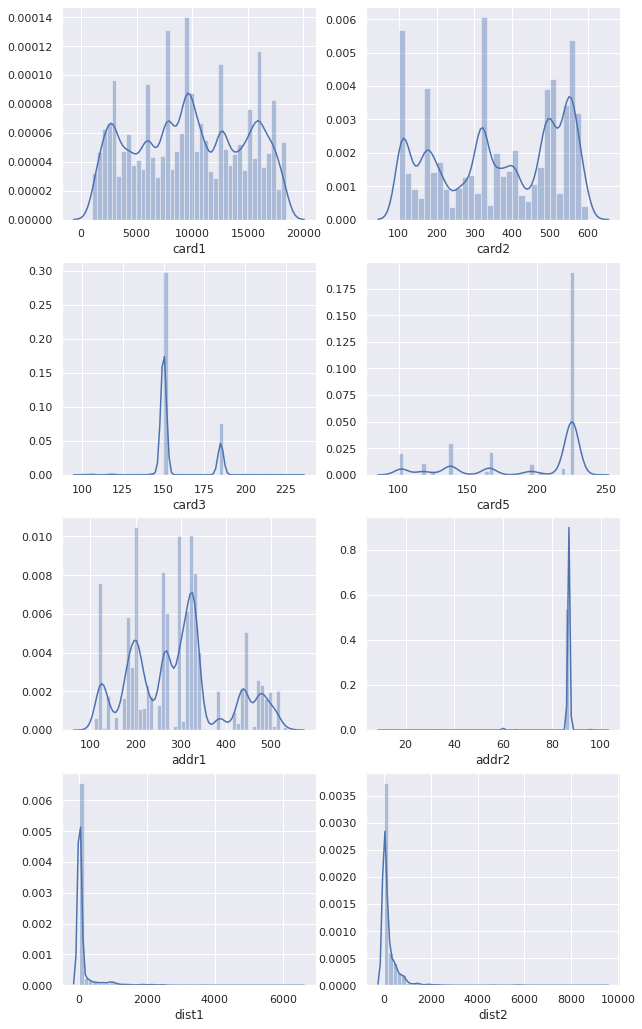

In [139]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,18))
sns.distplot(sample['card1'], ax=ax[0,0])
sns.distplot(sample['card2'], ax=ax[0,1])
sns.distplot(sample['card3'], ax=ax[1,0])
sns.distplot(sample['card5'], ax=ax[1,1])
sns.distplot(sample['addr1'], ax=ax[2,0])
sns.distplot(sample['addr2'], ax=ax[2,1])
sns.distplot(sample['dist1'], ax=ax[3,0])
sns.distplot(sample['dist2'], ax=ax[3,1])

In [14]:
sample.to_csv('./data/sample.csv', header=True, index=True)

In [7]:
types = {'TransactionAmt': 'float32',
         'ProductCD': 'category',
         'addr1': 'float32',
         'addr2': 'category',
         'dist1': 'float32',
         'dist2': 'float32',
         'P_emaildomain': 'category',
         'R_emaildomain': 'category',
         'card1': 'float32',
         'card2': 'float32',
         'card3': 'category',
         'card4': 'category',
         'card5': 'category',
         'card6': 'category'}

types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({f'V{i}': 'float32' for i in range(1, 340)})
types.update({(f'id_0{i}' if i<10 else f'id_{i}'): 'float32' for i in range(1, 12)})
types.update({f'id_{i}': 'category' for i in range(12, 39)})
types.update({'DeviceType': 'category', 'DeviceInfo': 'category'})

In [6]:
data = pandas.read_csv('./data/sample.csv', header=0, dtype=types).set_index('TransactionID')

In [7]:
data.drop(columns=['TransactionDT'], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3564207
Columns: 432 entries, isFraud to DeviceInfo
dtypes: category(46), float32(385), int64(1)
memory usage: 75.3 MB


In [9]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [8]:
y.value_counts()

0    28493
1    20663
Name: isFraud, dtype: int64

In [94]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [95]:
X_ = X.copy()
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns
X_[numerical] = mean_imp.fit_transform(X[numerical])
X_[categorical] = mode_imp.fit_transform(X[categorical])

In [96]:
X_.isnull().sum()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
                 ..
id_36             0
id_37             0
id_38             0
DeviceType        0
DeviceInfo        0
Length: 431, dtype: int64

## Visualization

In [14]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [15]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,4,18268.0,583.0,29,3,64,1,251.000000,30,...,38,2,46,2,0,0,1,0,0,660
2987240,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987243,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987245,37.098000,0,13413.0,103.0,48,3,20,1,291.504517,30,...,20,2,46,2,0,0,1,1,1,385
2987288,155.520996,0,16578.0,545.0,48,3,64,1,291.504517,30,...,37,2,46,2,0,0,0,0,1,660


In [16]:
X_ = MinMaxScaler().fit_transform(X_)

In [17]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

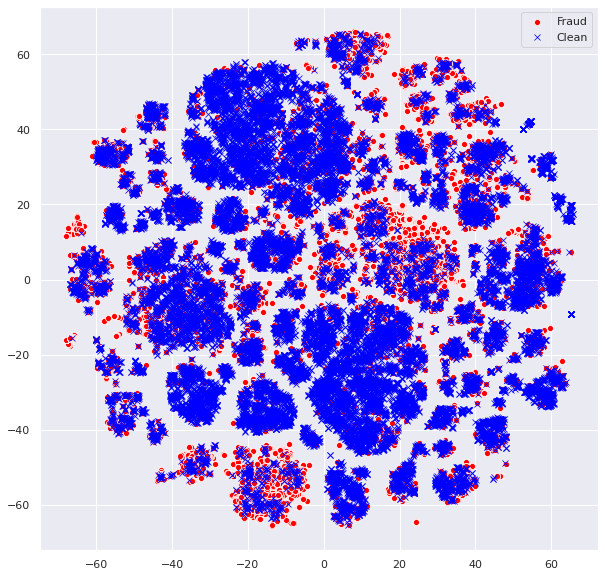

In [18]:
y_ = y.to_numpy()
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[y_==1, 0], y=X_[y_==1, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[y_==0, 0], y=X_[y_==0, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [19]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

In [26]:
X_ = X.copy()

In [27]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [28]:
variance_filter = VarianceThreshold(threshold=0)
variance_filter.fit(X_)

VarianceThreshold(threshold=0)

In [29]:
constant_columns = [column for column in X_.columns if column not in X_.columns[variance_filter.get_support()]]
constant_columns

['M1', 'V305', 'id_27']

In [30]:
tester = Hypot()

mapping = {k: 'cont' for k in numerical}
mapping.update({k: 'cat' for k in categorical})

del mapping['M1']
del mapping['V305']
del mapping['id_27']


In [31]:
p = tester.test(data=X_, mapping=mapping)

In [32]:
p

,TransactionAmt,addr1,dist1,dist2,card1,card2,C1,C2,C3,C4,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionAmt,1.00000,0.00131,0.00004,0.65583,0.60845,0.00000,0.00000,0.00000,0.16504,0.00014,...,0.00000,0.00000,0.00134,0.00000,0.92492,0.00000,0.00000,0.00000,0.00000,0.0
addr1,0.00131,1.00000,0.41671,0.82297,0.00000,0.00000,0.69752,0.80166,0.60050,0.62084,...,0.01363,0.00000,0.00000,0.00000,0.00000,0.60375,0.00000,0.01033,0.00106,1.0
dist1,0.00004,0.41671,1.00000,1.00000,0.00231,0.00003,0.65669,0.76031,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN
dist2,0.65583,0.82297,1.00000,1.00000,0.94389,0.17448,0.63851,0.18238,0.18496,0.52964,...,0.00000,0.99336,0.00000,0.69277,0.06558,0.00000,0.12137,0.31000,0.17496,0.0
card1,0.60845,0.00000,0.00231,0.94389,1.00000,0.30175,0.31173,0.51062,0.18072,0.10849,...,0.00000,0.01617,0.00004,0.08325,0.00002,0.08255,0.00202,0.00000,0.00002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_36,0.00000,0.60375,1.00000,0.00000,0.08255,0.00001,0.51355,0.57731,0.00000,0.28916,...,0.00000,0.31492,0.00000,0.64068,0.00000,1.00000,0.77175,0.00000,0.00000,0.0
id_37,0.00000,0.00000,1.00000,0.12137,0.00202,0.00000,0.00000,0.00000,0.18254,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.77175,1.00000,0.00000,0.00000,0.0
id_38,0.00000,0.01033,1.00000,0.31000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.0
DeviceType,0.00000,0.00106,1.00000,0.17496,0.00002,0.00006,0.00000,0.00000,0.00595,0.00000,...,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.0


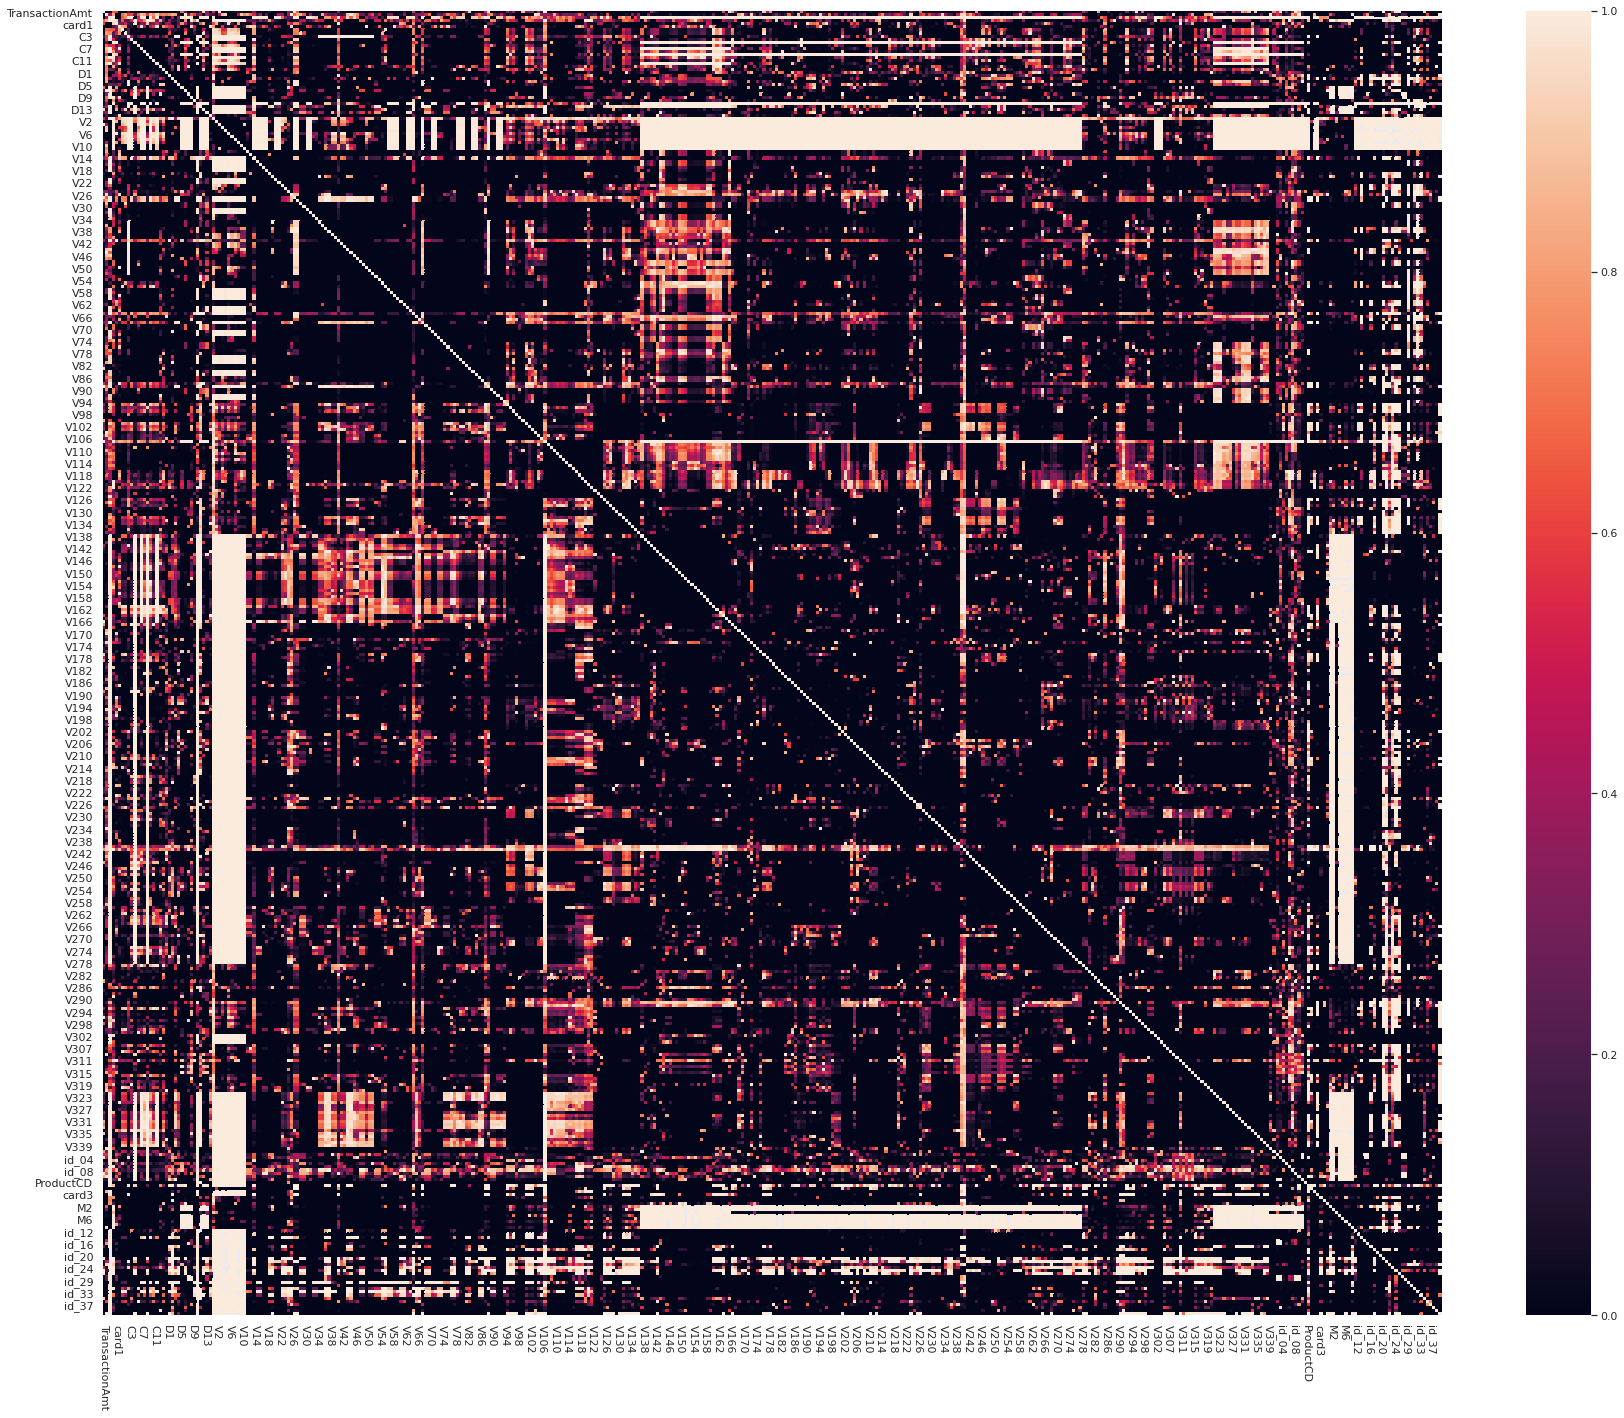

In [33]:
plt.figure(figsize=(30,24))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=270)
plt.show()

# Modeling

## Base Dataset

In [140]:
X_ = X[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']].copy()

In [141]:
X_p = X_[y==1]
X_n = X_[y==0]

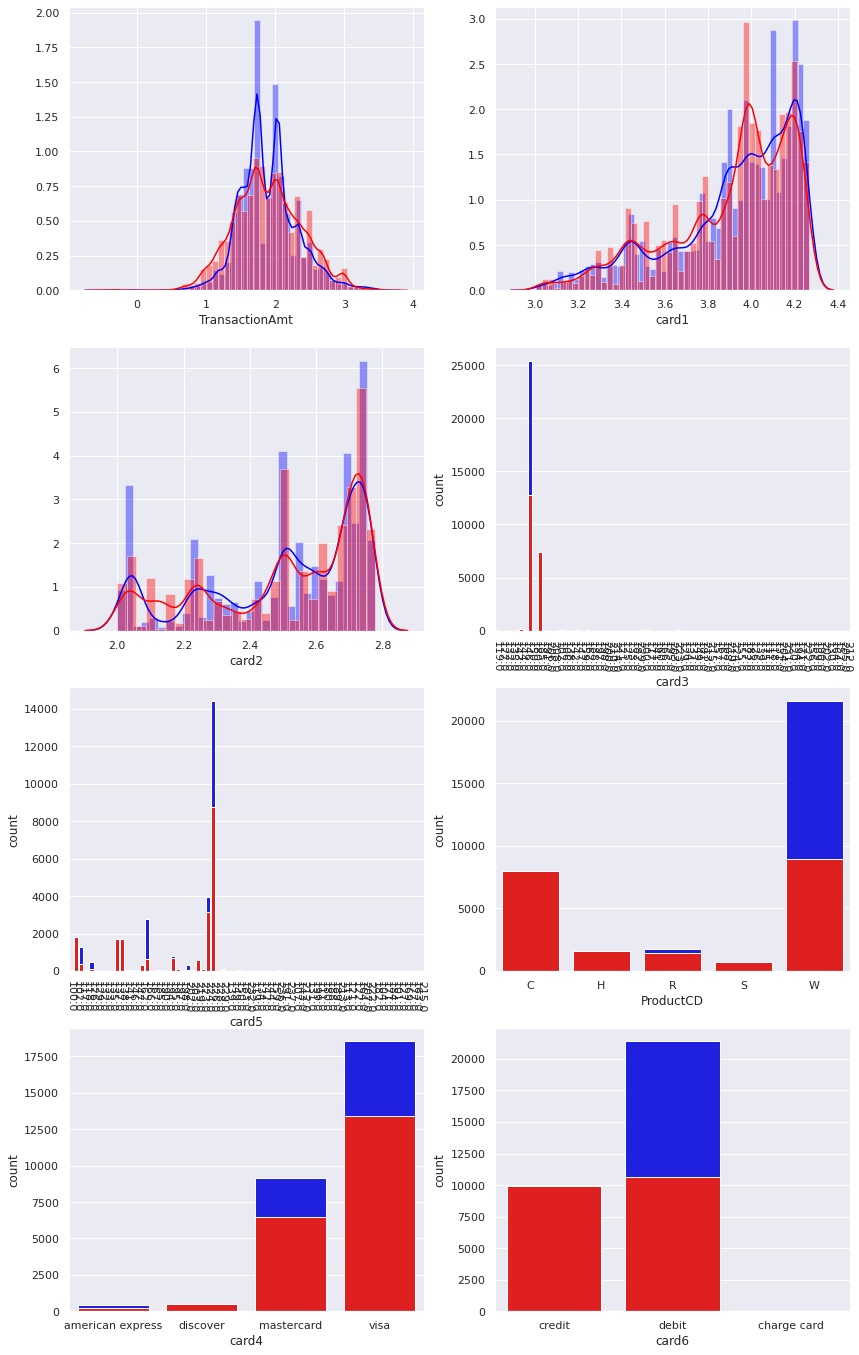

In [59]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,24))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.countplot(x='card3', data=X_n, ax=ax[1,1], color='blue')
sns.countplot(x='card3', data=X_p, ax=ax[1,1], color='red')
sns.countplot(x='card5', data=X_n, ax=ax[2,0], color='blue')
sns.countplot(x='card5', data=X_p, ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')
ax[1,1].tick_params(axis='x', labelrotation=270)
ax[2,0].tick_params(axis='x', labelrotation=270)

## Baseline Model

In [11]:
def encode(col):
    encoder = LabelEncoder()
    values = col.cat.categories.values
    labels = encoder.fit_transform(values)
    #labels = [i for i in range(len(categories))]
    col = col.cat.rename_categories(labels)
    #print(col.cat.categories)
    return col

In [145]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [148]:
X_.isnull().sum()

TransactionAmt      0
card1               0
card2             854
card3             117
card5             417
ProductCD           0
card4             120
card6             117
dtype: int64

In [149]:
X_[numerical] = numpy.log10(X_[numerical].add(1)) 

In [150]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6
TransactionID,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1
2987240,1.580902,4.127558,2.017033,48,20,0,3,1
2987243,1.580902,4.127558,2.017033,48,20,0,3,1
2987245,1.580902,4.127558,2.017033,48,20,0,3,1
2987288,2.194573,4.219558,2.737193,48,64,0,3,1


In [3]:
def ml_pipeline(X, y, n_splits, model, impute=True, visualize=True, polynomial=False, printout=True, smote=False):
    
    categorical = X.select_dtypes(include=['category']).columns
    numerical = X.select_dtypes(exclude=['category']).columns

        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs', 'f_importance'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[], f_importance=Counter({}))
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
        
        X_train, X_test, y_train, y_test = X.iloc[train_index, :].copy(deep=True), X.iloc[test_index, :].copy(deep=True), y.iloc[train_index].copy(deep=True), y.iloc[test_index].copy(deep=True)
        
        if impute:
            mean_imp = SimpleImputer(strategy='mean')
            mode_imp = SimpleImputer(strategy='most_frequent')
            X_train[numerical] = mean_imp.fit_transform(X_train[numerical]) 
            X_train[categorical] = mode_imp.fit_transform(X_train[categorical]) 
            X_test[numerical] = mean_imp.transform(X_test[numerical]) 
            X_test[categorical] = mode_imp.transform(X_test[categorical])
        else:
            X_train[categorical] = X_train[categorical].astype('int32')
            X_test[categorical] = X_test[categorical].astype('int32')
        
        if polynomial:
            
            pol = PolynomialFeatures(interaction_only=True)
            pol_train = pandas.DataFrame(data=pol.fit_transform(X_train[polynomial]),
                                         columns=pol.get_feature_names(X_train[polynomial].columns),
                                         index=X_train.index)
            
            pol_train.drop(columns=polynomial, inplace=True)
            X_train = X_train.join(pol_train, how='left')
            pol_test = pandas.DataFrame(data=pol.transform(X_test[polynomial]),
                                        columns=pol.get_feature_names(X_test[polynomial].columns),
                                        index=X_test.index)
            
            pol_test.drop(columns=polynomial, inplace=True)
            X_test = X_test.join(pol_test, how='left')
            
            if smote:
                categorical_features = [X.columns.get_loc(column) for column in X[categorical]]
                resampler = SMOTENC(sampling_strategy='minority', categorical_features=categorical_features, random_state=SEED, n_jobs=JOBS, k_neighbors=5)
                X_train, y_train = resampler.fit_resample(X_train, y_train)
                X_train[categorical] = X_train[categorical].astype('int32')
                y_train = y_train.astype('int32')

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
        
        
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.f_importance += Counter(model.get_booster().get_score(importance_type="gain"))
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        if printout:
            print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    keys = numpy.array(list(output.f_importance.keys()))
    values = numpy.array(list(output.f_importance.values()))
    sorter = numpy.argsort(values)[::-1]
    keys = keys[sorter]
    values = values[sorter]
    
    output.f_importance = keys
    
    if visualize:
    
        plt.figure(figsize=(20,10))
        if len(keys) > 100:
            sns.barplot(x=keys[0:100], y=values[0:100])
        else:
            sns.barplot(x=keys, y=values)
        plt.xticks(rotation=270)
        plt.show()
    
    return output

In [25]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
lr_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

AttributeError: 'LogisticRegression' object has no attribute 'get_booster'

## XGBoost

In [19]:
X_ = X[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']].copy()

In [20]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [21]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_[numerical] = numpy.log10(X_[numerical].add(1)) 

In [22]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6
TransactionID,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1
2987240,1.580902,4.127558,2.017033,48,20,0,3,1
2987243,1.580902,4.127558,2.017033,48,20,0,3,1
2987245,1.580902,4.127558,2.017033,48,20,0,3,1
2987288,2.194573,4.219558,2.737193,48,64,0,3,1


precision: 0.7450, recall: 0.6459, f1: 0.6919, aucPR: 0.7807, aucROC: 0.8334
precision: 0.7599, recall: 0.6570, f1: 0.7047, aucPR: 0.8052, aucROC: 0.8462
precision: 0.7698, recall: 0.6875, f1: 0.7263, aucPR: 0.8062, aucROC: 0.8555
precision: 0.7577, recall: 0.6704, f1: 0.7114, aucPR: 0.8045, aucROC: 0.8504
precision: 0.7670, recall: 0.6549, f1: 0.7065, aucPR: 0.8091, aucROC: 0.8524
precision: 0.7576, recall: 0.6534, f1: 0.7017, aucPR: 0.7911, aucROC: 0.8416
precision: 0.7712, recall: 0.6689, f1: 0.7164, aucPR: 0.8088, aucROC: 0.8515
precision: 0.7583, recall: 0.6878, f1: 0.7213, aucPR: 0.7998, aucROC: 0.8470
precision: 0.7593, recall: 0.6612, f1: 0.7069, aucPR: 0.8018, aucROC: 0.8485
precision: 0.7551, recall: 0.6641, f1: 0.7067, aucPR: 0.7849, aucROC: 0.8405
Final - precision: 0.7601, recall: 0.6651, f1: 0.7094, aucPR: 0.7992, aucROC: 0.8467


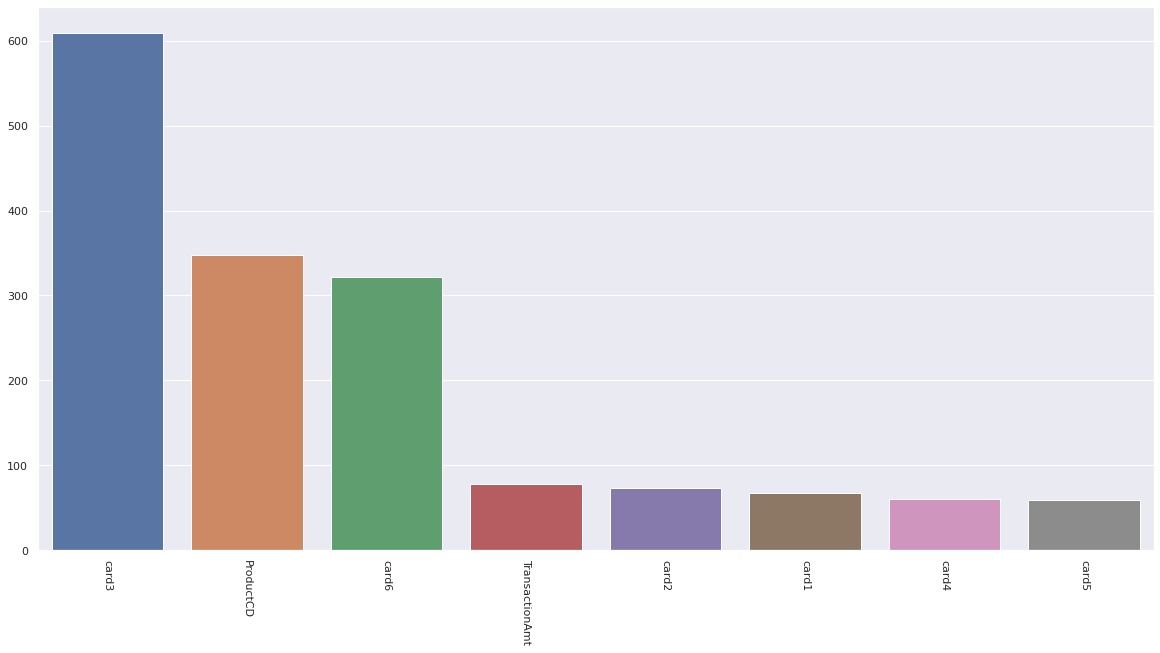

In [23]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7455, recall: 0.6560, f1: 0.6979, aucPR: 0.7869, aucROC: 0.8408
precision: 0.7674, recall: 0.6768, f1: 0.7193, aucPR: 0.8104, aucROC: 0.8499
precision: 0.7598, recall: 0.6918, f1: 0.7242, aucPR: 0.8117, aucROC: 0.8576
precision: 0.7605, recall: 0.6931, f1: 0.7252, aucPR: 0.8117, aucROC: 0.8575
precision: 0.7716, recall: 0.6752, f1: 0.7202, aucPR: 0.8168, aucROC: 0.8618
precision: 0.7666, recall: 0.6660, f1: 0.7128, aucPR: 0.7933, aucROC: 0.8445
precision: 0.7728, recall: 0.6767, f1: 0.7215, aucPR: 0.8114, aucROC: 0.8546
precision: 0.7601, recall: 0.7023, f1: 0.7301, aucPR: 0.8038, aucROC: 0.8511
precision: 0.7628, recall: 0.6864, f1: 0.7225, aucPR: 0.8054, aucROC: 0.8545
precision: 0.7578, recall: 0.6738, f1: 0.7133, aucPR: 0.7953, aucROC: 0.8477
Final - precision: 0.7625, recall: 0.6798, f1: 0.7187, aucPR: 0.8047, aucROC: 0.8520


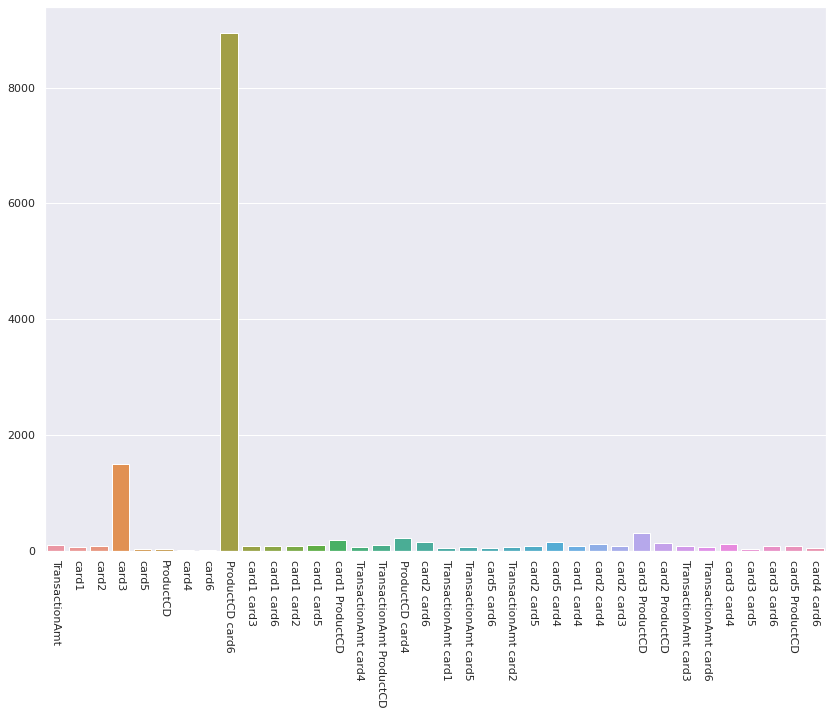

In [198]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_poly = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

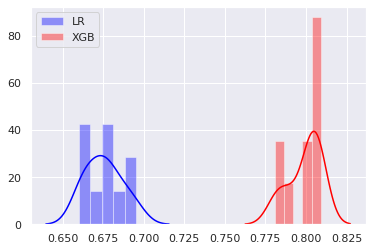

In [199]:
plt.figure()
sns.distplot(lr_base.aucs, color='blue', bins=5, label='LR')
sns.distplot(xgb_base.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [200]:
ttest_rel(lr_base.aucs, xgb_base.aucs)

Ttest_relResult(statistic=-76.78877962938272, pvalue=5.451063237900627e-14)

## Feature Expansion

### C features

In [224]:
C = X.loc[:, 'C1':'C14']

In [225]:
C_p = C[y==1]
C_n = C[y==0]

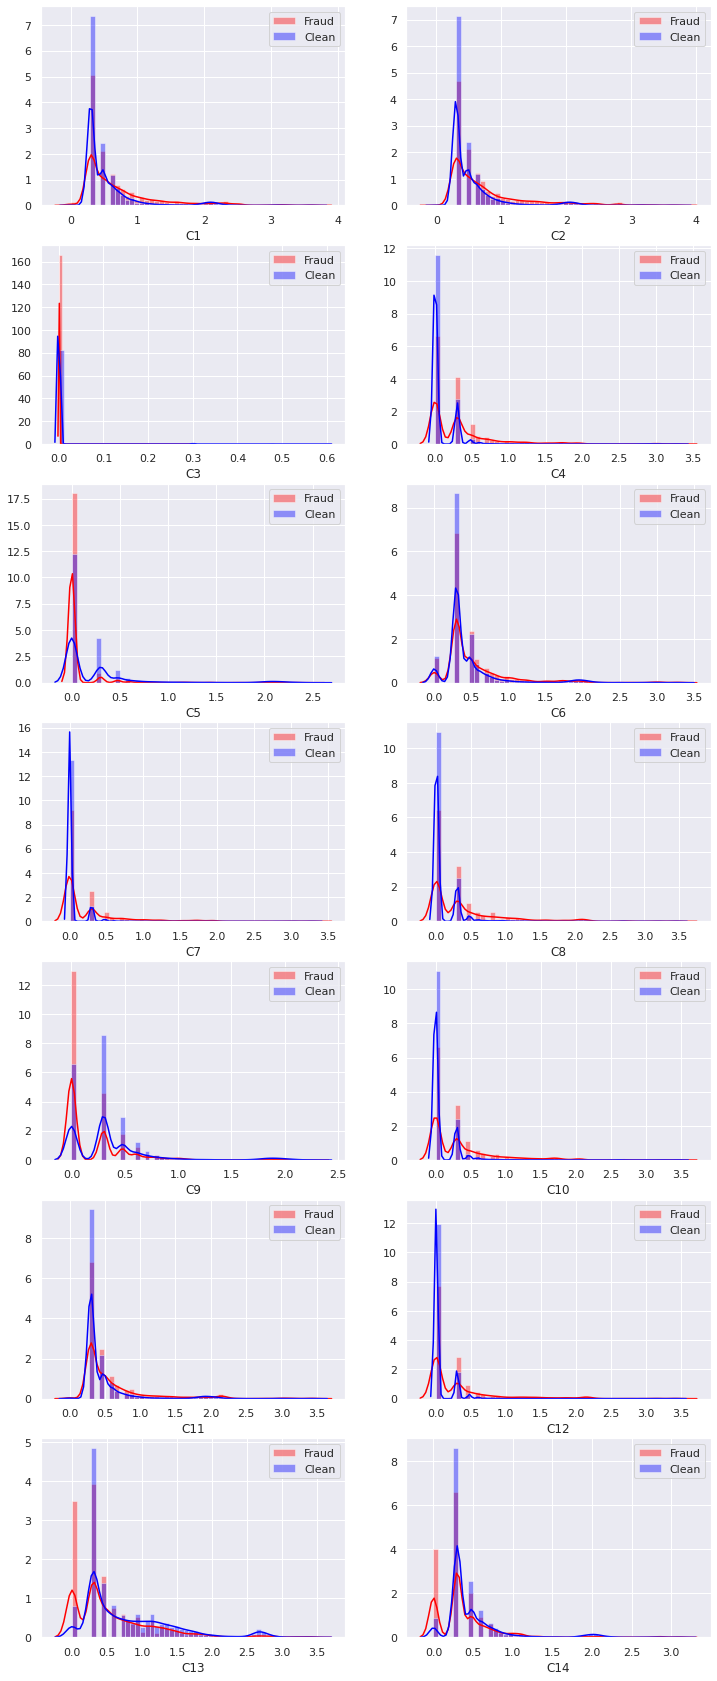

In [203]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    

In [226]:
XC = X_base.join(C, how='inner')

In [227]:
XC.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [246]:
X_ = XC.copy()

In [247]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [248]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_[numerical] = numpy.log10(X_[numerical].add(1)) 

In [249]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,0.0,0.477121,0.00000,0.00000,0.477121,0.00000,0.30103,0.00000,0.69897,0.477121
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000


precision: 0.8742, recall: 0.7702, f1: 0.8189, aucPR: 0.9152, aucROC: 0.9253
precision: 0.8698, recall: 0.7658, f1: 0.8145, aucPR: 0.9161, aucROC: 0.9253
precision: 0.8621, recall: 0.7804, f1: 0.8192, aucPR: 0.9191, aucROC: 0.9298
precision: 0.8735, recall: 0.7953, f1: 0.8325, aucPR: 0.9225, aucROC: 0.9343
precision: 0.8701, recall: 0.7715, f1: 0.8179, aucPR: 0.9175, aucROC: 0.9282
precision: 0.8782, recall: 0.7609, f1: 0.8154, aucPR: 0.9115, aucROC: 0.9222
precision: 0.8564, recall: 0.7536, f1: 0.8018, aucPR: 0.9101, aucROC: 0.9221
precision: 0.8433, recall: 0.7633, f1: 0.8013, aucPR: 0.9069, aucROC: 0.9196
precision: 0.8588, recall: 0.7449, f1: 0.7978, aucPR: 0.9062, aucROC: 0.9195
precision: 0.8570, recall: 0.7628, f1: 0.8072, aucPR: 0.9115, aucROC: 0.9216
Final - precision: 0.8643, recall: 0.7669, f1: 0.8126, aucPR: 0.9137, aucROC: 0.9248


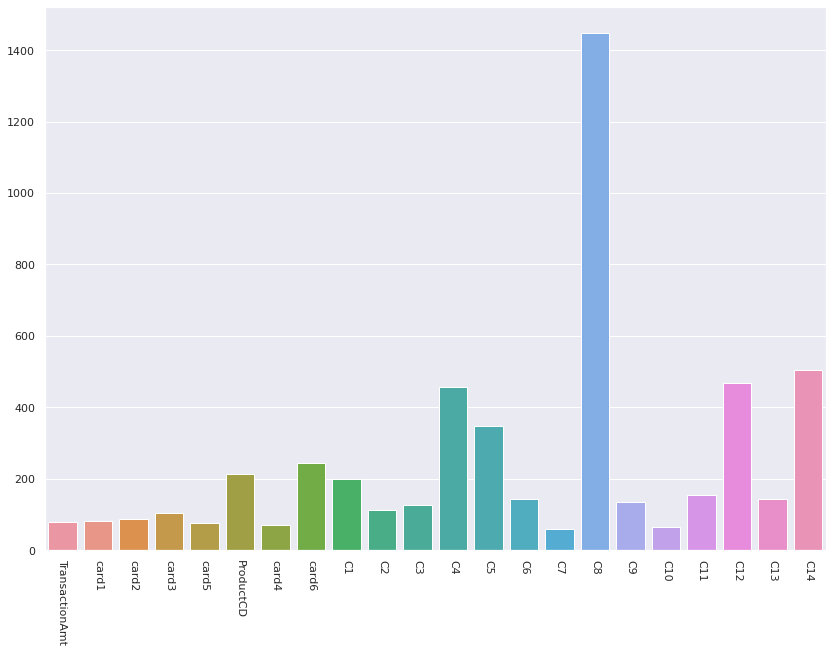

In [214]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_c = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

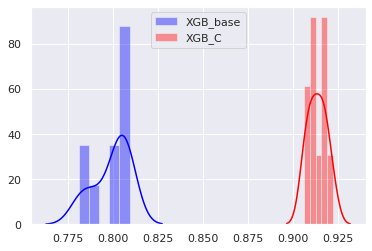

In [215]:
plt.figure()
sns.distplot(xgb_base.aucs, color='blue', bins=5, label='XGB_base')
sns.distplot(xgb_c.aucs, color='red', bins=5, label='XGB_C')
plt.legend()

In [216]:
ttest_rel(xgb_base.aucs, xgb_c.aucs)

Ttest_relResult(statistic=-34.74595986238927, pvalue=6.691690890557443e-11)

In [232]:
C_sum = X_[[f'C{i}' for i in range(1,15)]].sum(axis=1)

In [233]:
X_['C_sum'] = C_sum
X_.drop(columns=[f'C{i}' for i in range(1,15)], inplace=True)

In [234]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C_sum
TransactionID,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,3.385606
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,2.408240
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,2.709270
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,2.885361
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,2.709270


precision: 0.7954, recall: 0.6923, f1: 0.7403, aucPR: 0.8464, aucROC: 0.8744
precision: 0.8266, recall: 0.6942, f1: 0.7547, aucPR: 0.8543, aucROC: 0.8792
precision: 0.8088, recall: 0.7121, f1: 0.7574, aucPR: 0.8584, aucROC: 0.8860
precision: 0.8153, recall: 0.7265, f1: 0.7684, aucPR: 0.8637, aucROC: 0.8896
precision: 0.8153, recall: 0.7009, f1: 0.7538, aucPR: 0.8625, aucROC: 0.8864
precision: 0.8108, recall: 0.6762, f1: 0.7374, aucPR: 0.8481, aucROC: 0.8744
precision: 0.8175, recall: 0.6917, f1: 0.7493, aucPR: 0.8542, aucROC: 0.8800
precision: 0.7942, recall: 0.7115, f1: 0.7506, aucPR: 0.8497, aucROC: 0.8762
precision: 0.7953, recall: 0.7052, f1: 0.7476, aucPR: 0.8504, aucROC: 0.8765
precision: 0.7934, recall: 0.6931, f1: 0.7399, aucPR: 0.8430, aucROC: 0.8740
Final - precision: 0.8073, recall: 0.7004, f1: 0.7499, aucPR: 0.8531, aucROC: 0.8797


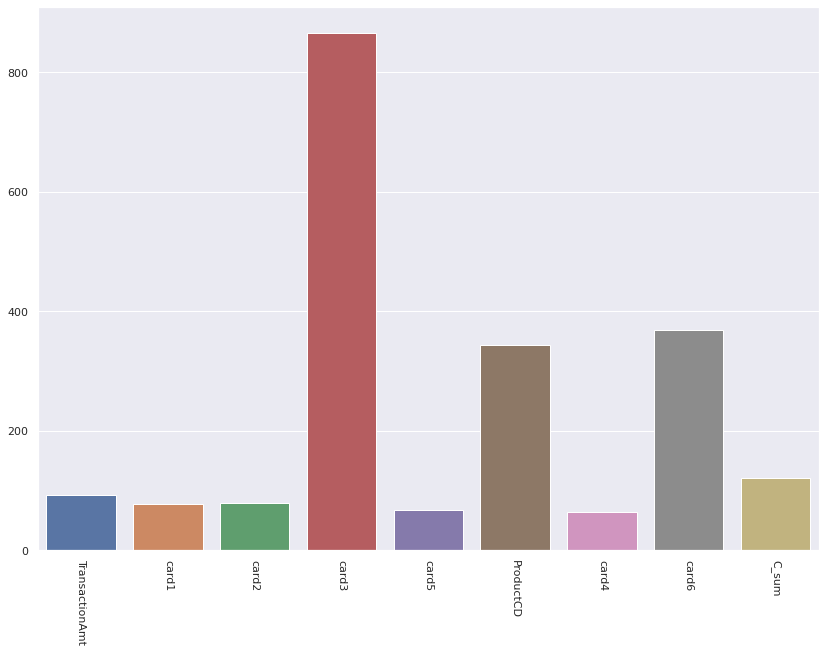

In [235]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

### Adress features

In [253]:
G = X[['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']]

In [254]:
G.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987203,251.0,87.0,NaN,NaN,aol.com,NaN
2987240,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987243,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987245,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987288,NaN,NaN,NaN,NaN,outlook.com,outlook.com


In [255]:
G_p = G[y==1]
G_n = G[y==0]

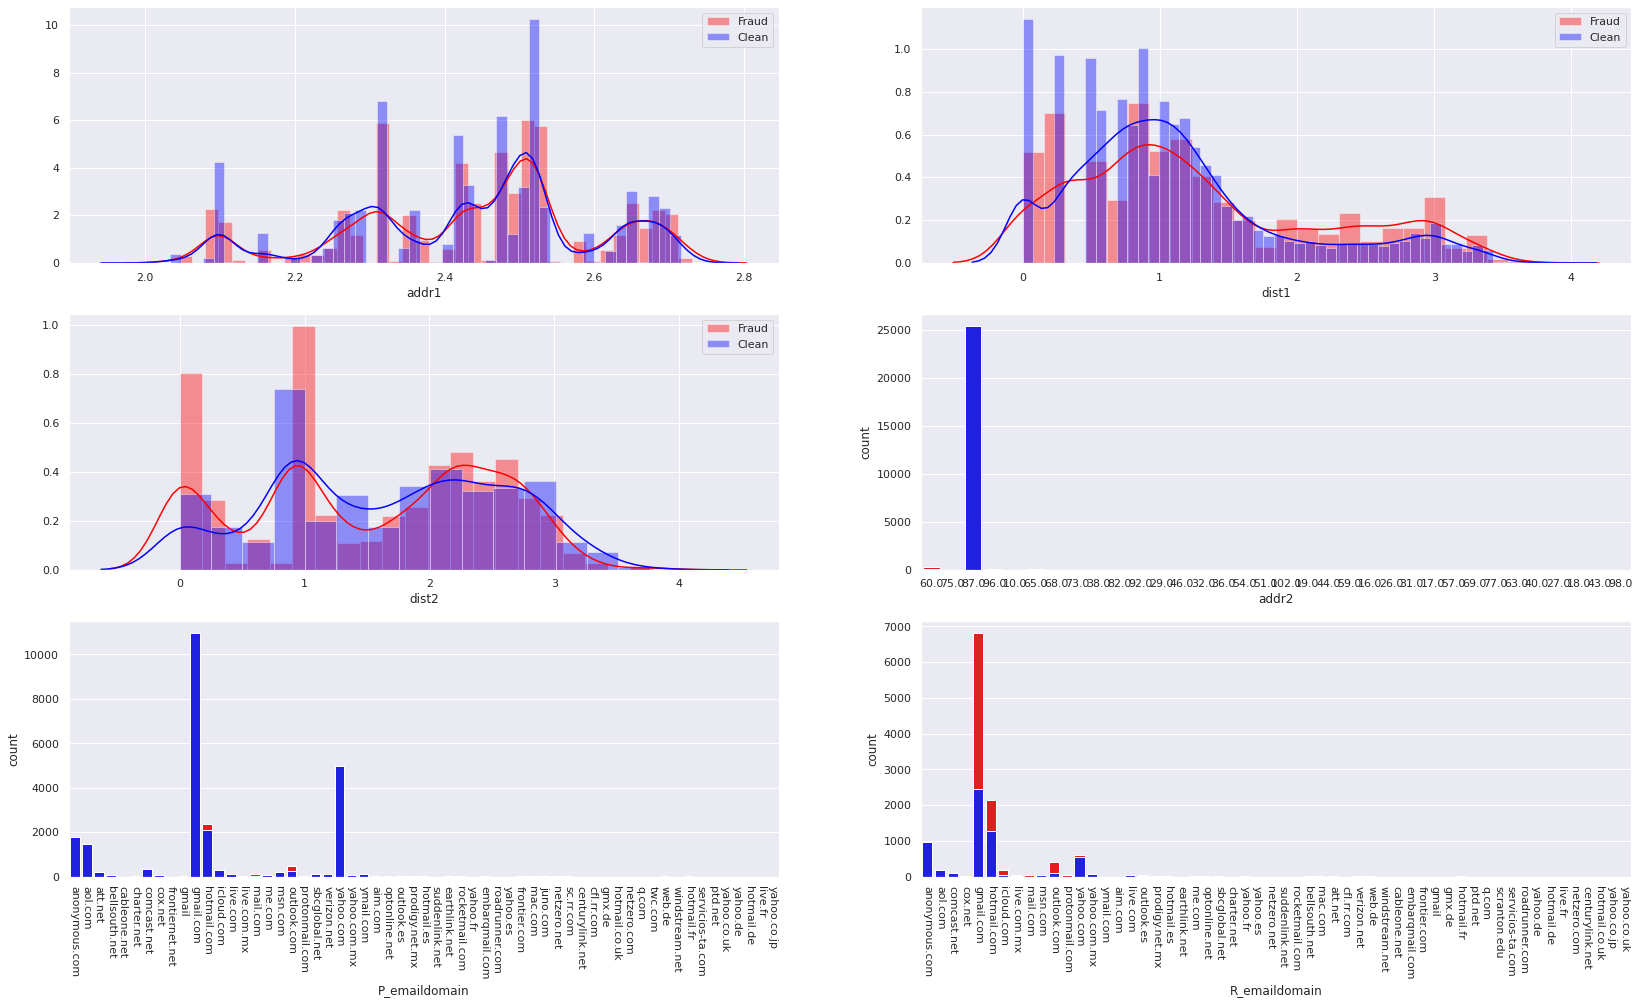

In [240]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(28,16))

features = ['addr1', 'dist1', 'dist2']
idx = 0
for row in range(0, 2):
    for col in range(0, 2):
        if idx < 3:
            sns.distplot(numpy.log10(G_p[features[idx]].add(1)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(G_n[features[idx]].add(1)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            idx += 1
            
sns.countplot(G_p['addr2'], color='red', ax=ax[1, 1], label='Fraud')
sns.countplot(G_n['addr2'], color='blue', ax=ax[1, 1], label='Clean')
sns.countplot(G_p['P_emaildomain'], color='red', ax=ax[2, 0], label='Fraud')
sns.countplot(G_n['P_emaildomain'], color='blue', ax=ax[2, 0], label='Clean')
sns.countplot(G_p['R_emaildomain'], color='red', ax=ax[2, 1], label='Fraud')
sns.countplot(G_n['R_emaildomain'], color='blue', ax=ax[2, 1], label='Clean')
ax[2,1].tick_params(axis='x', labelrotation=270)
ax[2,0].tick_params(axis='x', labelrotation=270)
plt.show()

In [256]:
XCG = XC.join(G, how='inner')

In [257]:
XCG.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,1.0,0.0,4.0,2.0,251.0,87.0,NaN,NaN,aol.com,NaN
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,outlook.com,outlook.com


In [260]:
X_ = XCG.copy()

In [261]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [262]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_[numerical] = numpy.log10(X_[numerical].add(1))

In [263]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,0.30103,0.00000,0.69897,0.477121,2.401401,30,NaN,NaN,2,NaN
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,0.30103,0.30103,0.00000,0.000000,NaN,NaN,NaN,NaN,19,18
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,NaN,NaN,NaN,NaN,19,18
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,0.30103,0.30103,0.00000,0.000000,NaN,NaN,NaN,NaN,19,18
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,NaN,NaN,NaN,NaN,35,33


precision: 0.8774, recall: 0.7862, f1: 0.8293, aucPR: 0.9231, aucROC: 0.9332
precision: 0.8783, recall: 0.7891, f1: 0.8313, aucPR: 0.9226, aucROC: 0.9303
precision: 0.8684, recall: 0.7920, f1: 0.8284, aucPR: 0.9239, aucROC: 0.9347
precision: 0.8799, recall: 0.7977, f1: 0.8368, aucPR: 0.9253, aucROC: 0.9362
precision: 0.8787, recall: 0.7924, f1: 0.8333, aucPR: 0.9282, aucROC: 0.9368
precision: 0.8855, recall: 0.7711, f1: 0.8243, aucPR: 0.9205, aucROC: 0.9304
precision: 0.8779, recall: 0.7798, f1: 0.8259, aucPR: 0.9218, aucROC: 0.9321
precision: 0.8508, recall: 0.7836, f1: 0.8158, aucPR: 0.9153, aucROC: 0.9274
precision: 0.8684, recall: 0.7764, f1: 0.8198, aucPR: 0.9195, aucROC: 0.9318
precision: 0.8707, recall: 0.7822, f1: 0.8241, aucPR: 0.9196, aucROC: 0.9294
Final - precision: 0.8736, recall: 0.7850, f1: 0.8269, aucPR: 0.9220, aucROC: 0.9322


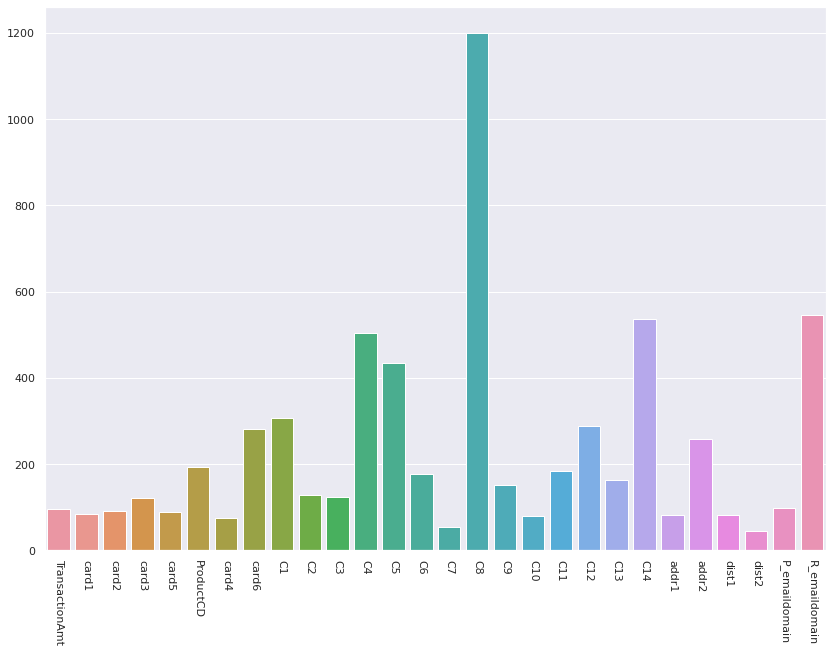

In [265]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cg = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

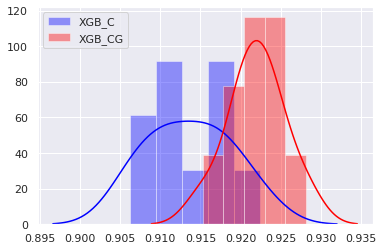

In [266]:
plt.figure()
sns.distplot(xgb_c.aucs, color='blue', bins=5, label='XGB_C')
sns.distplot(xgb_cg.aucs, color='red', bins=5, label='XGB_CG')
plt.legend()

In [267]:
ttest_rel(xgb_cg.aucs, xgb_c.aucs)

Ttest_relResult(statistic=8.348984906556057, pvalue=1.571214081970686e-05)

### M features

In [268]:
features = [f'M{i}' for i in range(1,10)]

In [269]:
M = X.loc[:, features]

In [270]:
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987203,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN
2987240,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987243,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987245,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987288,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN


In [271]:
M_p = M[y==1]
M_n = M[y==0]

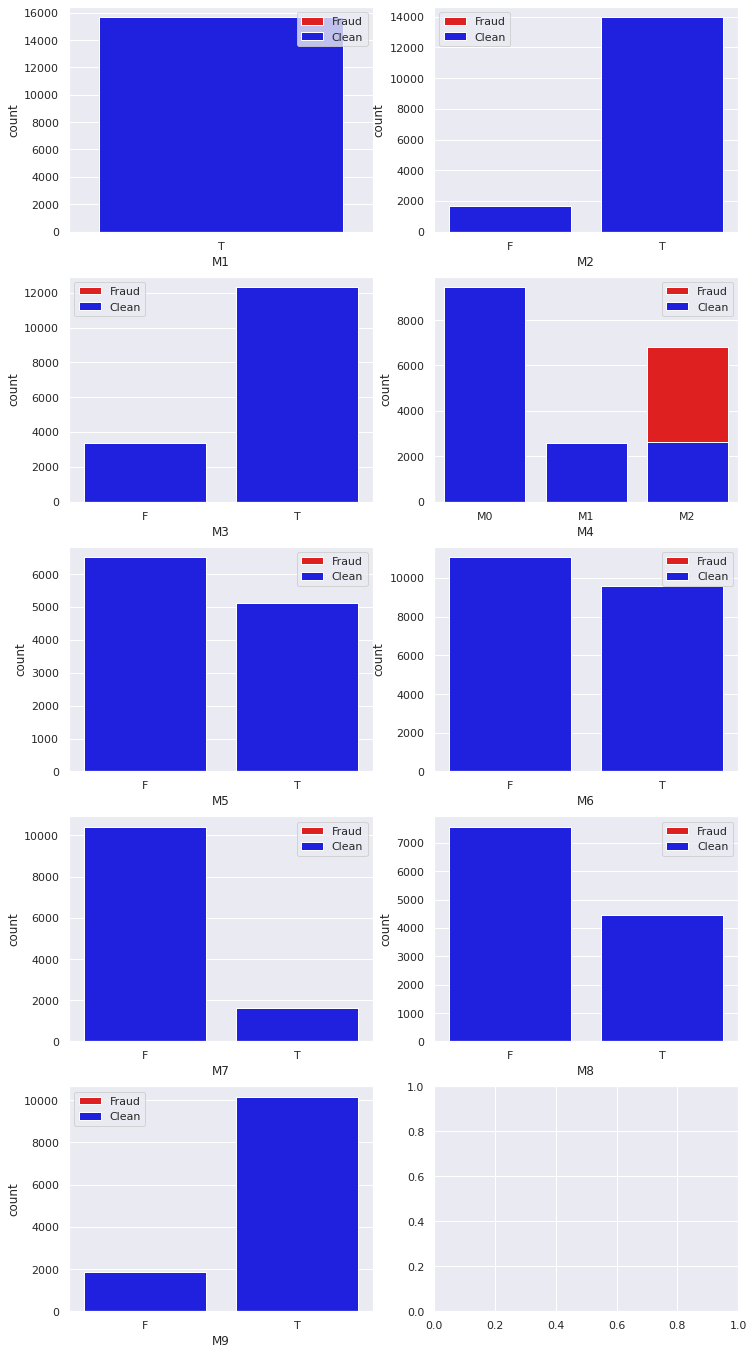

In [272]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

feature = 1
for row in range(0, 5):
    for col in range(0, 2):
        if feature < 10:
            sns.countplot(M_p[f'M{feature}'], color='red', ax=ax[row,col], label='Fraud')
            sns.countplot(M_n[f'M{feature}'], color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1


In [273]:
XCGM = XCG.join(M, how='inner')

In [274]:
XCGM.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,NaN,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,hotmail.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,hotmail.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,hotmail.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,outlook.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN


In [275]:
X_ = XCGM.copy()

In [276]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [277]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_[numerical] = numpy.log10(X_[numerical].add(1))

In [278]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,18,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,18,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,18,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,33,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN


precision: 0.8778, recall: 0.7992, f1: 0.8367, aucPR: 0.9253, aucROC: 0.9358
precision: 0.8884, recall: 0.8123, f1: 0.8486, aucPR: 0.9296, aucROC: 0.9372
precision: 0.8666, recall: 0.8079, f1: 0.8363, aucPR: 0.9290, aucROC: 0.9398
precision: 0.8858, recall: 0.8151, f1: 0.8490, aucPR: 0.9319, aucROC: 0.9425
precision: 0.8822, recall: 0.8083, f1: 0.8436, aucPR: 0.9314, aucROC: 0.9407
precision: 0.8859, recall: 0.7933, f1: 0.8371, aucPR: 0.9237, aucROC: 0.9327
precision: 0.8736, recall: 0.7861, f1: 0.8275, aucPR: 0.9231, aucROC: 0.9333
precision: 0.8571, recall: 0.7924, f1: 0.8234, aucPR: 0.9193, aucROC: 0.9313
precision: 0.8644, recall: 0.7865, f1: 0.8236, aucPR: 0.9226, aucROC: 0.9352
precision: 0.8783, recall: 0.7962, f1: 0.8352, aucPR: 0.9233, aucROC: 0.9329
Final - precision: 0.8760, recall: 0.7997, f1: 0.8361, aucPR: 0.9259, aucROC: 0.9362


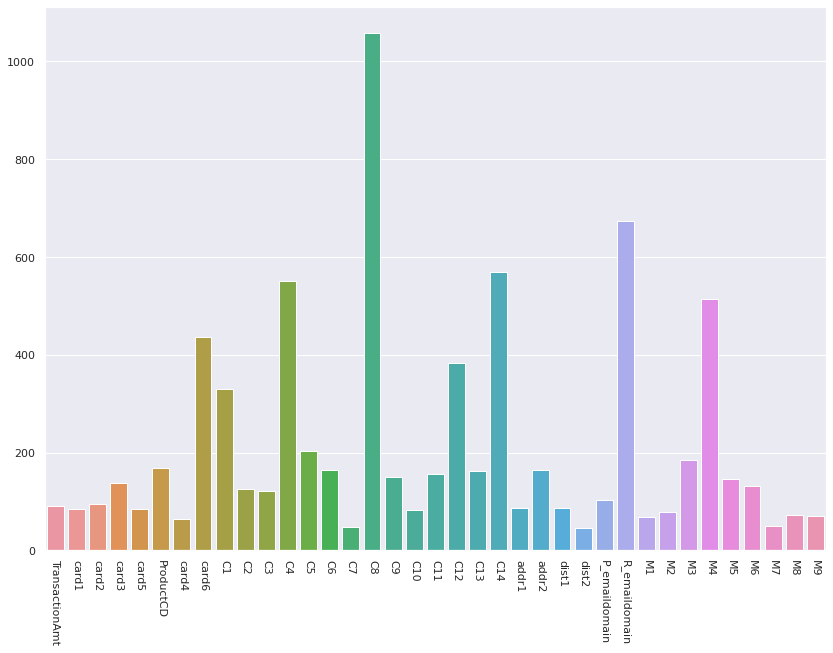

In [279]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgm = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

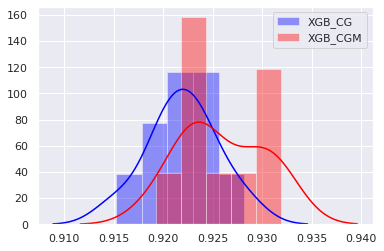

In [280]:
plt.figure()
sns.distplot(xgb_cg.aucs, color='blue', bins=5, label='XGB_CG')
sns.distplot(xgb_cgm.aucs, color='red', bins=5, label='XGB_CGM')
plt.legend()

In [281]:
ttest_rel(xgb_cgm.aucs, xgb_cg.aucs)

Ttest_relResult(statistic=6.854487651943371, pvalue=7.435849990153218e-05)

### D features

In [282]:
features = [f'D{i}' for i in range(1,16)]

In [283]:
D = X[features]

In [284]:
D.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987203,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,374.0
2987240,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987243,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987245,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987288,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0


In [285]:
D_p = D[y==1]
D_n = D[y==0]

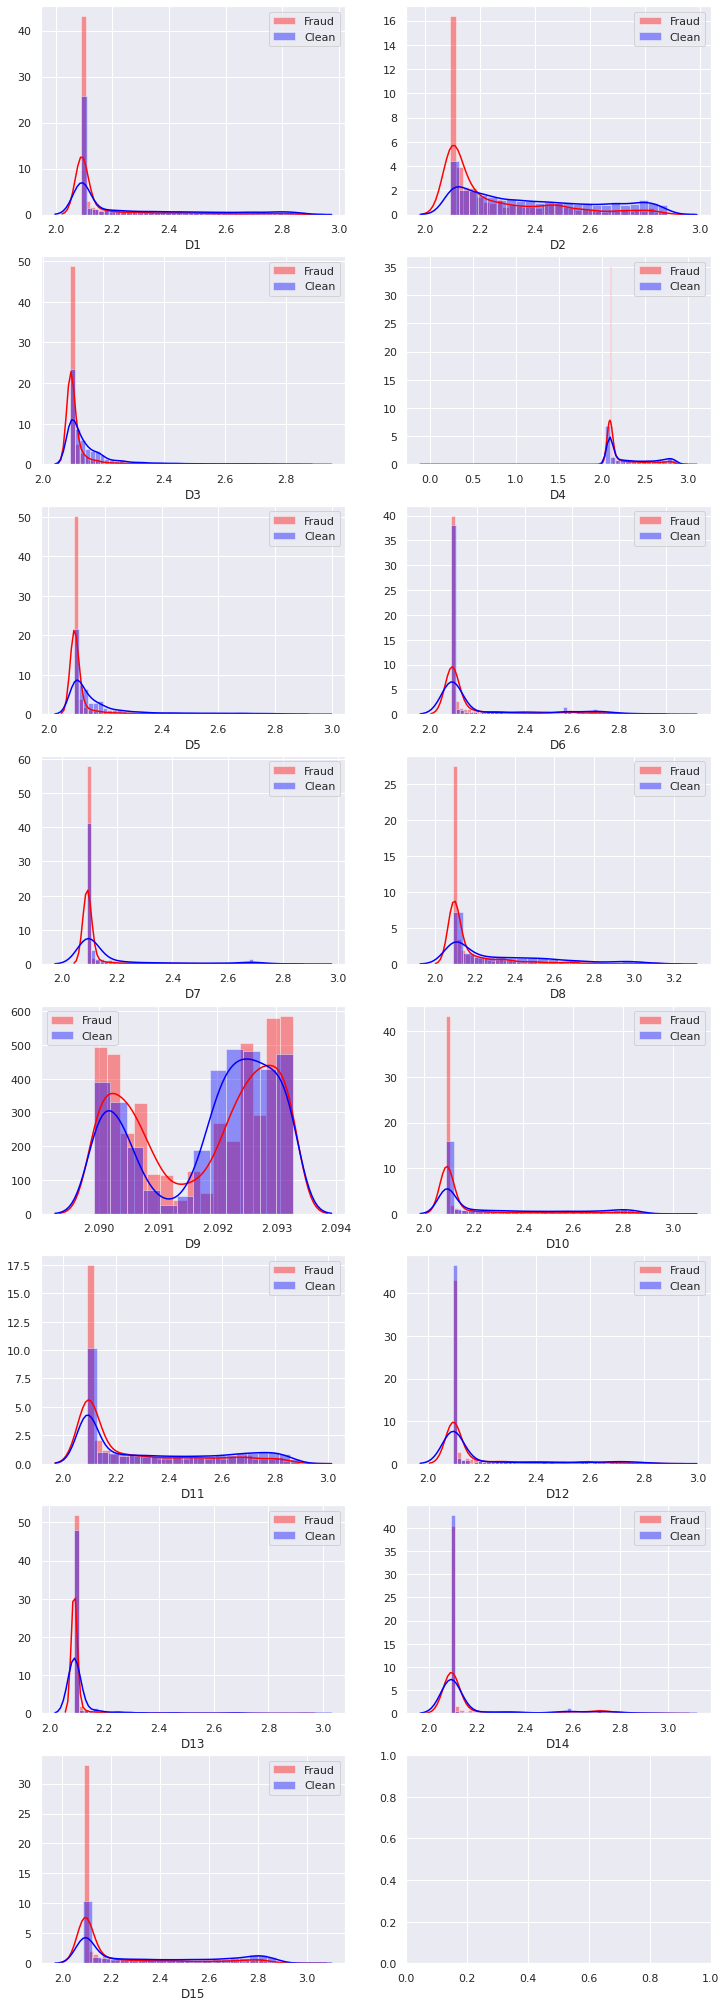

In [286]:
f, ax = plt.subplots(nrows=8, ncols=2, figsize=(12, 36))

feature = 1
for row in range(0, 8):
    for col in range(0, 2):
        if feature < 16:
            sns.distplot(numpy.log10(D_p[f'D{feature}'].add(123)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(D_n[f'D{feature}'].add(123)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1

In [287]:
XCGMD = XCGM.join(D, how='inner')

In [288]:
XCGMD.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,374.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0


In [387]:
X_ = XCGMD.copy()

In [388]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [389]:
negatives = X_[numerical].loc[:, X_.min()<0].min()
negatives

C1         0.0
C2         0.0
C3         0.0
C4         0.0
C5         0.0
C6         0.0
C7         0.0
C8         0.0
C9         0.0
C10        0.0
C11        0.0
C12        0.0
C13        0.0
C14        0.0
dist1      0.0
dist2      0.0
D1         0.0
D2         0.0
D3         0.0
D4      -122.0
D5         0.0
D6         0.0
D7         0.0
D8         0.0
D9         0.0
D10        0.0
D11        0.0
D12        0.0
D13        0.0
D14        0.0
D15       -2.0
dtype: float32

In [390]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_.loc[:, negatives.index] = X_.loc[:, negatives.index].add(-negatives.values)
X_[numerical] =  numpy.log10(X_[numerical].add(1))

In [391]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,NaN,NaN,NaN,NaN,1.908485,NaN,NaN,NaN,NaN,2.576341
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,0.0,NaN,1.663151,0.017729,0.000000,NaN,0.0,0.0,0.0,0.477121
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,0.0,0.0,1.663151,0.017729,0.000000,NaN,0.0,0.0,0.0,0.477121
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,0.0,0.0,1.663151,0.017729,0.000000,NaN,0.0,0.0,0.0,0.477121
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,0.0,NaN,NaN,NaN,0.000000,NaN,0.0,0.0,0.0,0.477121


precision: 0.8840, recall: 0.8186, f1: 0.8500, aucPR: 0.9324, aucROC: 0.9390
precision: 0.8795, recall: 0.8016, f1: 0.8388, aucPR: 0.9294, aucROC: 0.9369
precision: 0.8806, recall: 0.8133, f1: 0.8456, aucPR: 0.9321, aucROC: 0.9405
precision: 0.8854, recall: 0.8340, f1: 0.8589, aucPR: 0.9352, aucROC: 0.9454
precision: 0.8786, recall: 0.8195, f1: 0.8480, aucPR: 0.9354, aucROC: 0.9441
precision: 0.8884, recall: 0.8015, f1: 0.8427, aucPR: 0.9297, aucROC: 0.9371
precision: 0.8736, recall: 0.8025, f1: 0.8365, aucPR: 0.9274, aucROC: 0.9353
precision: 0.8672, recall: 0.8190, f1: 0.8424, aucPR: 0.9296, aucROC: 0.9414
precision: 0.8777, recall: 0.8132, f1: 0.8442, aucPR: 0.9346, aucROC: 0.9444
precision: 0.8713, recall: 0.8093, f1: 0.8391, aucPR: 0.9288, aucROC: 0.9380
Final - precision: 0.8786, recall: 0.8132, f1: 0.8446, aucPR: 0.9315, aucROC: 0.9402


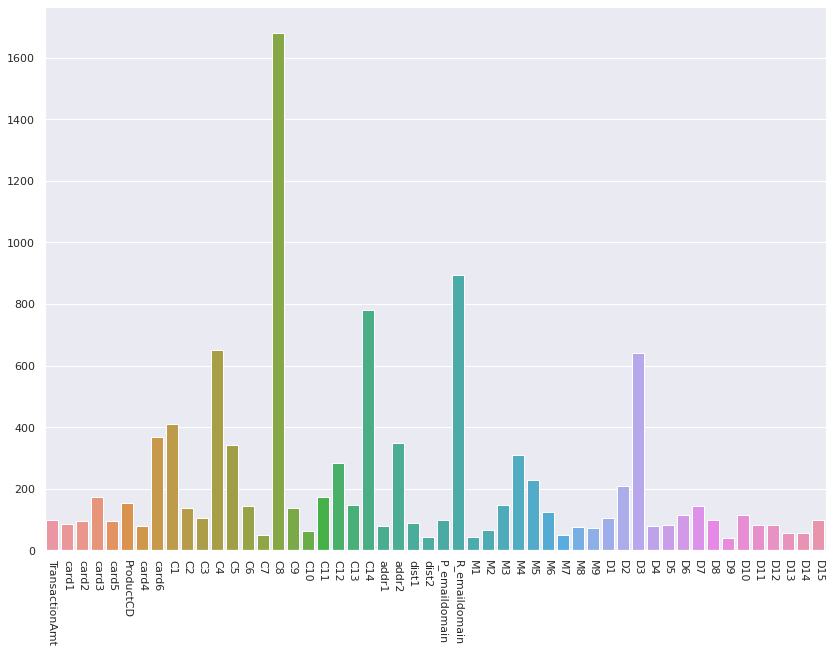

In [392]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmd = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

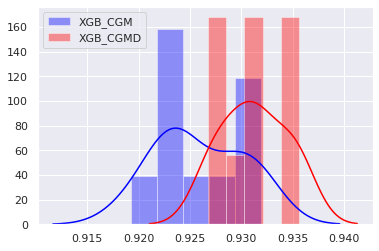

In [378]:
plt.figure()
sns.distplot(xgb_cgm.aucs, color='blue', bins=5, label='XGB_CGM')
sns.distplot(xgb_cgmd.aucs, color='red', bins=5, label='XGB_CGMD')
plt.legend()

In [379]:
ttest_rel(xgb_cgmd.aucs, xgb_cgm.aucs)

Ttest_relResult(statistic=6.832298678590193, pvalue=7.623283795217145e-05)

## V features

In [393]:
features = [f'V{i}' for i in range(1,340)]

In [394]:
V = X[features]

In [395]:
V.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [396]:
XCGMDV = XCGMD.join(V, how='inner')

In [397]:
XCGMDV.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [398]:
X_ = XCGMDV.copy()

In [399]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [400]:
negatives = X_[numerical].loc[:, X_.min()<0].min()

In [401]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_.loc[:, negatives.index] = X_.loc[:, negatives.index].add(-negatives.values)
X_[numerical] =  numpy.log10(X_[numerical].add(1))

In [402]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,29,64,4,3,1,0.477121,0.477121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,1.580902,4.127558,2.017033,48,20,0,3,1,0.000000,0.301030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,1.580902,4.127558,2.017033,48,20,0,3,1,0.301030,0.301030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,1.580902,4.127558,2.017033,48,20,0,3,1,0.477121,0.301030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,2.194573,4.219558,2.737193,48,64,0,3,1,0.301030,0.301030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


precision: 0.8875, recall: 0.8089, f1: 0.8464, aucPR: 0.9340, aucROC: 0.9390
precision: 0.8859, recall: 0.8002, f1: 0.8409, aucPR: 0.9318, aucROC: 0.9376
precision: 0.8870, recall: 0.8050, f1: 0.8440, aucPR: 0.9332, aucROC: 0.9402
precision: 0.8805, recall: 0.8238, f1: 0.8512, aucPR: 0.9323, aucROC: 0.9428
precision: 0.8828, recall: 0.8098, f1: 0.8447, aucPR: 0.9329, aucROC: 0.9406
precision: 0.8840, recall: 0.7928, f1: 0.8359, aucPR: 0.9263, aucROC: 0.9343
precision: 0.8772, recall: 0.7953, f1: 0.8342, aucPR: 0.9287, aucROC: 0.9348
precision: 0.8749, recall: 0.8093, f1: 0.8408, aucPR: 0.9281, aucROC: 0.9364
precision: 0.8907, recall: 0.8045, f1: 0.8454, aucPR: 0.9343, aucROC: 0.9432
precision: 0.8717, recall: 0.8025, f1: 0.8357, aucPR: 0.9285, aucROC: 0.9361
Final - precision: 0.8822, recall: 0.8052, f1: 0.8419, aucPR: 0.9310, aucROC: 0.9385


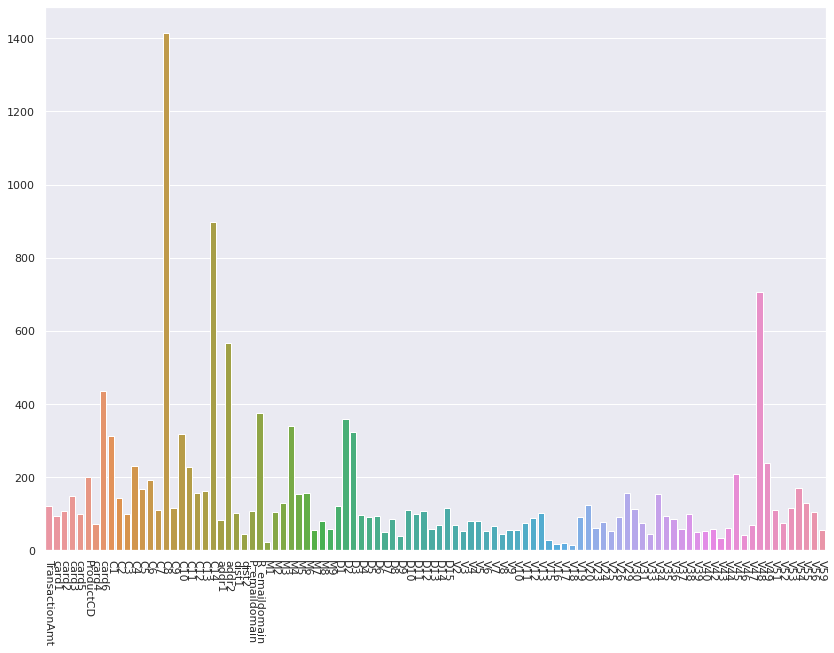

In [405]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmdv = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

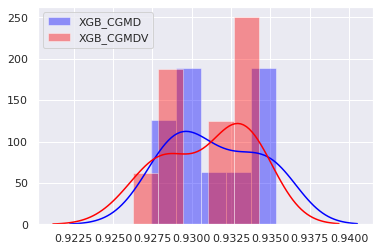

In [406]:
plt.figure()
sns.distplot(xgb_cgmd.aucs, color='blue', bins=5, label='XGB_CGMD')
sns.distplot(xgb_cgmdv.aucs, color='red', bins=5, label='XGB_CGMDV')
plt.legend()

In [407]:
ttest_rel(xgb_cgmd.aucs, xgb_cgmdv.aucs)

Ttest_relResult(statistic=0.6913082697806721, pvalue=0.5068103406878772)

## Identity features

In [14]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [15]:
X_ = X.copy()

In [16]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [17]:
negatives = X_[numerical].loc[:, X_.min()<0].min()

In [18]:
X_[categorical] = X_[categorical].apply(encode, axis=0)
X_.loc[:, negatives.index] = X_.loc[:, negatives.index].add(-negatives.values)
X_[numerical] =  numpy.log10(X_[numerical].add(1))

In [19]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4,4.261715,2.766413,29,3,64,1,2.401401,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,1.580902,0,4.127558,2.017033,48,3,20,1,NaN,NaN,...,20,NaN,NaN,NaN,0,0,1,1,1,385
2987243,1.580902,0,4.127558,2.017033,48,3,20,1,NaN,NaN,...,20,NaN,NaN,NaN,0,0,1,1,1,385
2987245,1.580902,0,4.127558,2.017033,48,3,20,1,NaN,NaN,...,20,NaN,NaN,NaN,0,0,1,1,1,385
2987288,2.194573,0,4.219558,2.737193,48,3,64,1,NaN,NaN,...,37,NaN,NaN,NaN,0,0,0,0,1,NaN


precision: 0.8900, recall: 0.8021, f1: 0.8438, aucPR: 0.9354, aucROC: 0.9418
precision: 0.8783, recall: 0.7992, f1: 0.8369, aucPR: 0.9308, aucROC: 0.9362
precision: 0.8788, recall: 0.8036, f1: 0.8395, aucPR: 0.9323, aucROC: 0.9408
precision: 0.8864, recall: 0.8233, f1: 0.8537, aucPR: 0.9356, aucROC: 0.9460
precision: 0.8781, recall: 0.8020, f1: 0.8384, aucPR: 0.9321, aucROC: 0.9406
precision: 0.8903, recall: 0.7972, f1: 0.8412, aucPR: 0.9283, aucROC: 0.9339
precision: 0.8822, recall: 0.7899, f1: 0.8335, aucPR: 0.9275, aucROC: 0.9348
precision: 0.8781, recall: 0.8122, f1: 0.8439, aucPR: 0.9303, aucROC: 0.9387
precision: 0.8867, recall: 0.7996, f1: 0.8409, aucPR: 0.9321, aucROC: 0.9409
precision: 0.8806, recall: 0.8136, f1: 0.8458, aucPR: 0.9320, aucROC: 0.9388
Final - precision: 0.8829, recall: 0.8043, f1: 0.8417, aucPR: 0.9316, aucROC: 0.9392


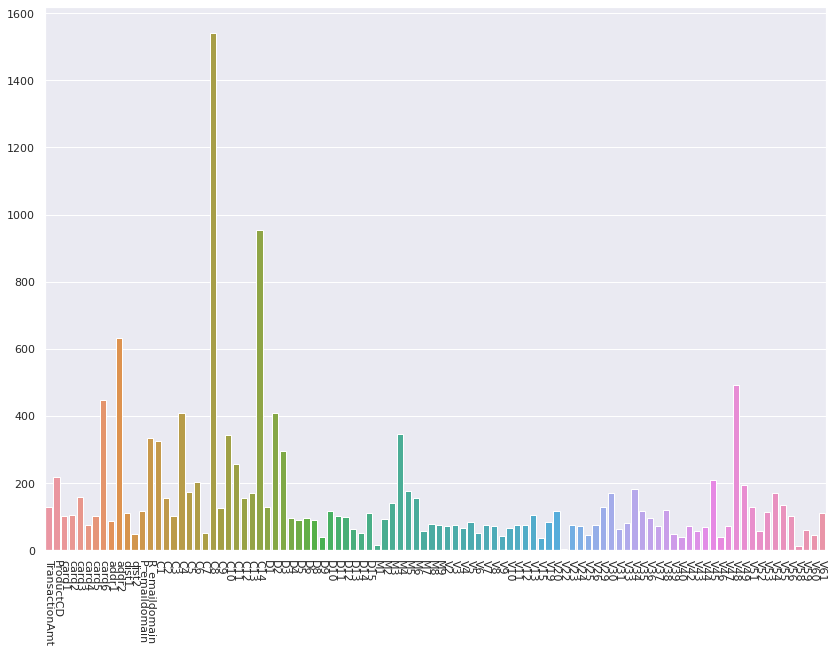

In [414]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_full = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

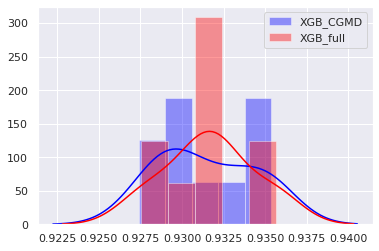

In [415]:
plt.figure()
sns.distplot(xgb_cgmd.aucs, color='blue', bins=5, label='XGB_CGMD')
sns.distplot(xgb_full.aucs, color='red', bins=5, label='XGB_full')
plt.legend()

In [416]:
ttest_rel(xgb_full.aucs, xgb_cgmdv.aucs)

Ttest_relResult(statistic=0.9682291274404067, pvalue=0.35822749673544485)

# Model optimization

## Iterative Imputer

In [20]:
X_ = X.copy()
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4,4.261715,2.766413,29.0,3.0,64.0,1.0,2.401401,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,1.580902,0,4.127558,2.017033,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987243,1.580902,0,4.127558,2.017033,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987245,1.580902,0,4.127558,2.017033,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987288,2.194573,0,4.219558,2.737193,48.0,3.0,64.0,1.0,NaN,NaN,...,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN


In [21]:
categorical = X_.select_dtypes(include=['category']).columns
numerical = X_.select_dtypes(exclude=['category']).columns

In [22]:
negatives = X_[numerical].loc[:, X_[numerical].min()<0].min()

In [23]:
X_[categorical] = X_[categorical].apply(encode, result_type='broadcast',axis=0).astype('category')
X_.loc[:, negatives.index] = X_.loc[:, negatives.index].add(-negatives.values)
X_[numerical] =  numpy.log10(X_[numerical].add(1))

In [24]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,0.562214,4.0,0.721127,0.575928,29.0,3.0,64.0,1.0,0.531658,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,0.411772,0.0,0.709911,0.479580,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987243,0.411772,0.0,0.709911,0.479580,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987245,0.411772,0.0,0.709911,0.479580,48.0,3.0,20.0,1.0,NaN,NaN,...,20.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,385.0
2987288,0.504413,0.0,0.717634,0.572546,48.0,3.0,64.0,1.0,NaN,NaN,...,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN


In [25]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3564207
Columns: 431 entries, TransactionAmt to DeviceInfo
dtypes: category(46), float32(385)
memory usage: 75.0 MB


In [438]:
iter_imp = IterativeImputer(max_iter=10, verbose=10, random_state=SEED)

In [439]:
I = iter_imp.fit_transform(X_)

[IterativeImputer] Completing matrix with shape (49156, 431)
[IterativeImputer] Ending imputation round 1/10, elapsed time 262.10
[IterativeImputer] Change: 10979.54048541034, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 2/10, elapsed time 701.11
[IterativeImputer] Change: 1997.9117073729872, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1381.46
[IterativeImputer] Change: 1621.0544311815813, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 4/10, elapsed time 2140.90
[IterativeImputer] Change: 2435.293029059702, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 5/10, elapsed time 2915.76
[IterativeImputer] Change: 576.5962566669847, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 6/10, elapsed time 3683.88
[IterativeImputer] Change: 734.5815393426651, scaled tolerance: 0.741 
[IterativeImputer] Ending imputation round 7/10, elapsed time 4470.77
[IterativeImputer] Chan

/home/vladimir/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [445]:
I = pandas.DataFrame(data=I, columns=X_.columns)

In [446]:
I.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2.649335,4.0,4.261715,2.766413,29.0,3.0,64.0,1.0,2.401401,30.000000,...,0.218836,5.157244,30.253654,-3.776699,-0.807487,0.087759,3.89851,-0.939923,0.208822,923.37998
1,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.409742,25.139791,...,20.000000,1.265267,80.889020,0.682905,0.000000,0.000000,1.00000,1.000000,1.000000,385.00000
2,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.399669,21.923309,...,20.000000,1.224676,340.776247,-0.325816,0.000000,0.000000,1.00000,1.000000,1.000000,385.00000
3,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.381315,21.918093,...,20.000000,1.226545,340.757618,-0.433803,0.000000,0.000000,1.00000,1.000000,1.000000,385.00000
4,2.194573,0.0,4.219558,2.737193,48.0,3.0,64.0,1.0,2.464652,22.346365,...,37.000000,1.421613,326.572857,-0.260575,0.000000,0.000000,0.00000,0.000000,1.000000,420.69862


In [450]:
I = numpy.abs(I)
I[categorical] = numpy.round(I[categorical]).astype('int32').astype('category')

In [451]:
I.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2.649335,4,4.261715,2.766413,29,3,64,1,2.401401,30,...,0,5,30,4,1,0,4,1,0,923
1,1.580902,0,4.127558,2.017033,48,3,20,1,2.409742,25,...,20,1,81,1,0,0,1,1,1,385
2,1.580902,0,4.127558,2.017033,48,3,20,1,2.399669,22,...,20,1,341,0,0,0,1,1,1,385
3,1.580902,0,4.127558,2.017033,48,3,20,1,2.381315,22,...,20,1,341,0,0,0,1,1,1,385
4,2.194573,0,4.219558,2.737193,48,3,64,1,2.464652,22,...,37,1,327,0,0,0,0,0,1,421


In [ ]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_full = ml_pipeline(X=I, y=y, n_splits=10, model=model, impute=False)

## Recursive Feature Elimination

In [19]:
def preprocess(X, impute=True, polynomial=False):
    
    categorical = X.select_dtypes(include=['category']).columns
    numerical = X.select_dtypes(exclude=['category']).columns
    #X.loc[:, categorical] = X.loc[:, categorical].astype('int32')
    
    if impute:
        mean_imp = SimpleImputer(strategy='mean')
        mode_imp = SimpleImputer(strategy='most_frequent')
        X.loc[:, numerical] = mean_imp.fit_transform(X.loc[:, numerical]) 
        X.loc[:, categorical] = mode_imp.fit_transform(X.loc[:, categorical])
    
    if polynomial:
        
        pol = PolynomialFeatures(interaction_only=True)
        pol_ = pandas.DataFrame(data=pol.fit_transform(X[polynomial]),
                                         columns=pol.get_feature_names(X[polynomial].columns),
                                         index=X.index)
            
        pol_.drop(columns=polynomial, inplace=True)
        X = X.join(pol_, how='left')
    
    X[categorical] = X[categorical].astype('category')

    return X
        

In [ ]:
xgb = XGBClassifier(random_state=SEED)

selector = RFECV(estimator=xgb,
                 step=1,
                 cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED),
                 n_jobs=JOBS,
                 verbose=10,
                 scoring='precision',
                 min_features_to_select=1,
                 )

filename = './artifacts/rfe_precision_xgb.pkl'
rfe = selector.fit(X_.to_numpy(), y.to_numpy().reshape(-1, ))
pickle.dump(obj=rfe, file=open(filename, 'wb'))

In [26]:
rfe_rf_recall = pickle.load(open('./artifacts/rfe_recall_xgb.pkl', 'rb'))

Text(0.5, 0, 'N features removed')

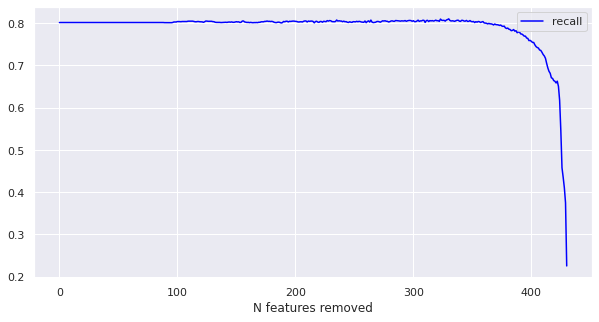

In [26]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(X_.columns)), y=rfe_rf_recall.grid_scores_[::-1], color='blue', label='recall')
plt.xlabel('N features removed')

precision: 0.8897, recall: 0.8075, f1: 0.8466, aucPR: 0.9333, aucROC: 0.9391
precision: 0.8879, recall: 0.8007, f1: 0.8420, aucPR: 0.9294, aucROC: 0.9359
precision: 0.8819, recall: 0.8055, f1: 0.8420, aucPR: 0.9353, aucROC: 0.9438
precision: 0.8859, recall: 0.8267, f1: 0.8553, aucPR: 0.9356, aucROC: 0.9444
precision: 0.8859, recall: 0.8190, f1: 0.8511, aucPR: 0.9349, aucROC: 0.9433
precision: 0.8902, recall: 0.7928, f1: 0.8387, aucPR: 0.9267, aucROC: 0.9325
precision: 0.8831, recall: 0.8078, f1: 0.8438, aucPR: 0.9311, aucROC: 0.9381
precision: 0.8808, recall: 0.8049, f1: 0.8412, aucPR: 0.9303, aucROC: 0.9389
precision: 0.8838, recall: 0.8098, f1: 0.8452, aucPR: 0.9353, aucROC: 0.9438
precision: 0.8767, recall: 0.8015, f1: 0.8374, aucPR: 0.9306, aucROC: 0.9383
Final - precision: 0.8846, recall: 0.8076, f1: 0.8443, aucPR: 0.9322, aucROC: 0.9398


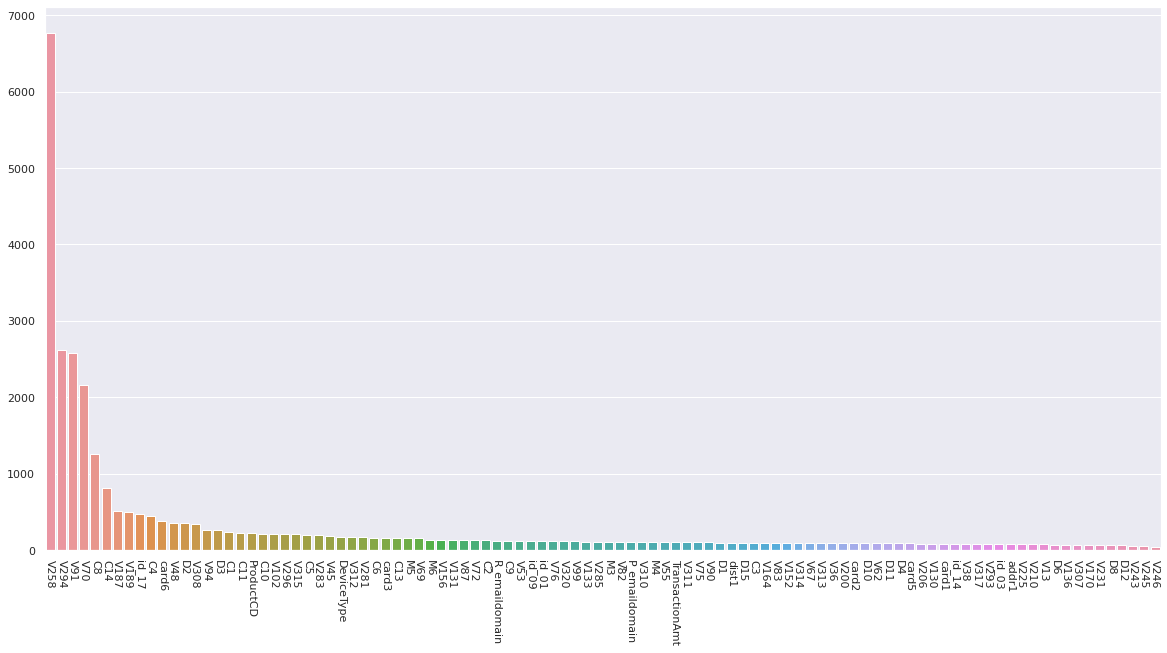

In [27]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_rfe = ml_pipeline(X=X_.loc[:, rfe_rf_recall.support_], y=y, n_splits=10, model=model)

## Polynomial Features

In [28]:
polynomial_f = xgb_rfe.f_importance.tolist()[0:30]
polynomial_f

['V258',
 'V294',
 'V91',
 'V70',
 'C8',
 'C14',
 'V187',
 'V189',
 'id_17',
 'C4',
 'card6',
 'V48',
 'D2',
 'V308',
 'V94',
 'D3',
 'C1',
 'C11',
 'ProductCD',
 'C10',
 'V102',
 'V296',
 'V315',
 'C5',
 'V283',
 'V45',
 'DeviceType',
 'V312',
 'V281',
 'C6']

precision: 0.8901, recall: 0.7992, f1: 0.8422, aucPR: 0.9341, aucROC: 0.9396
precision: 0.8845, recall: 0.8036, f1: 0.8421, aucPR: 0.9325, aucROC: 0.9380
precision: 0.8916, recall: 0.8041, f1: 0.8456, aucPR: 0.9330, aucROC: 0.9403
precision: 0.8857, recall: 0.8180, f1: 0.8505, aucPR: 0.9349, aucROC: 0.9438
precision: 0.8844, recall: 0.8112, f1: 0.8463, aucPR: 0.9340, aucROC: 0.9403
precision: 0.8870, recall: 0.8015, f1: 0.8421, aucPR: 0.9286, aucROC: 0.9349
precision: 0.8812, recall: 0.7933, f1: 0.8349, aucPR: 0.9279, aucROC: 0.9351
precision: 0.8750, recall: 0.8098, f1: 0.8411, aucPR: 0.9291, aucROC: 0.9383
precision: 0.8849, recall: 0.8078, f1: 0.8446, aucPR: 0.9324, aucROC: 0.9421
precision: 0.8721, recall: 0.7953, f1: 0.8319, aucPR: 0.9298, aucROC: 0.9366
Final - precision: 0.8837, recall: 0.8044, f1: 0.8421, aucPR: 0.9316, aucROC: 0.9389


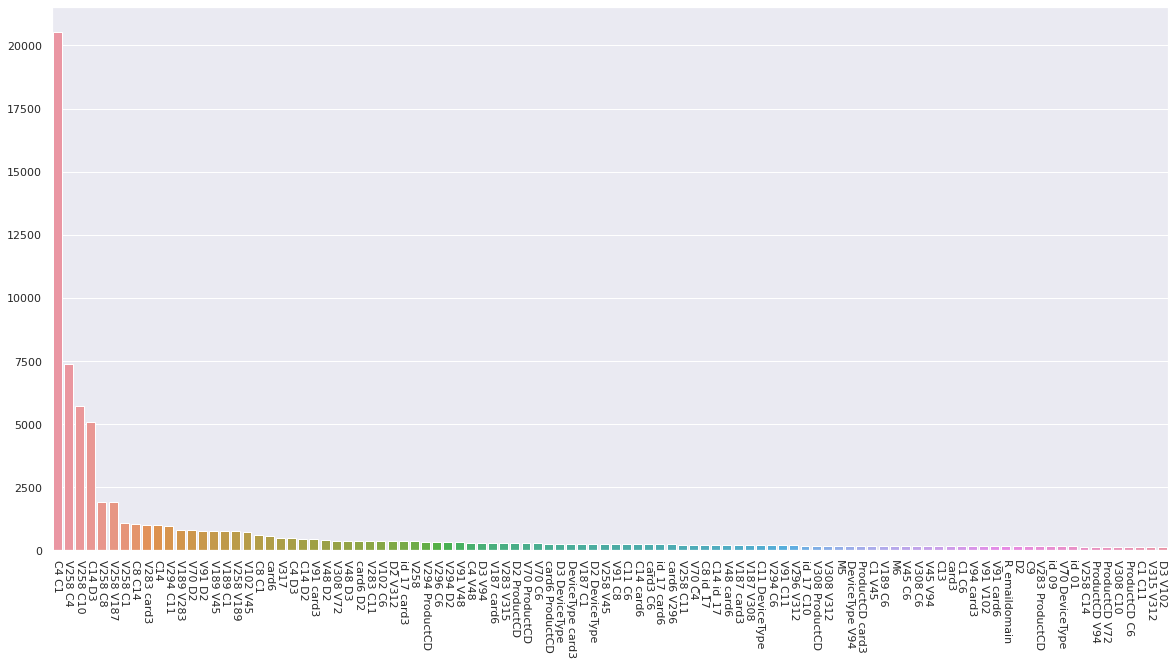

In [39]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_rfe_pol = ml_pipeline(X=X_.loc[:, rfe_rf_recall.support_], y=y, n_splits=10, model=model, polynomial=polynomial_f)

In [29]:
R_ = preprocess(X_, polynomial=polynomial_f)

In [30]:
R_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3564207
Columns: 867 entries, TransactionAmt to V281 C6
dtypes: category(46), float64(821)
memory usage: 311.9 MB


In [ ]:
xgb = XGBClassifier(random_state=SEED)

selector = RFECV(estimator=xgb,
                 step=1,
                 cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED),
                 n_jobs=JOBS,
                 verbose=10,
                 scoring='recall',
                 min_features_to_select=1,
                 )

filename = './artifacts/rfe_polynom_recall_xgb.pkl'
rfe = selector.fit(R_.to_numpy(), y.to_numpy().reshape(-1, ))
pickle.dump(obj=rfe, file=open(filename, 'wb'))

In [31]:
rfe_polynom_recall_xgb = pickle.load(open('./artifacts/rfe_polynom_recall_xgb.pkl', 'rb'))

Text(0.5, 0, 'N features removed')

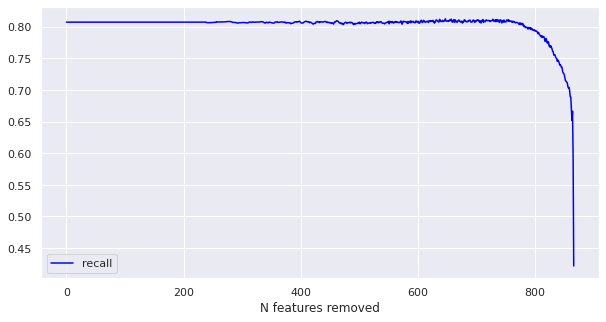

In [29]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(R_.columns)), y=rfe_polynom_recall_xgb.grid_scores_[::-1], color='blue', label='recall')
plt.xlabel('N features removed')

In [30]:
R_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,DeviceType V94,DeviceType card3,DeviceType V312,DeviceType C6,V94 card3,V94 V312,V94 C6,card3 V312,card3 C6,V312 C6
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.0,4.261715,2.766413,29.0,3.0,64.0,1.0,2.401401,30.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0,13.836515,0.0
2987240,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.437747,30.0,...,0.30103,48.0,0.0,0.30103,14.44944,0.0,0.090619,0.0,14.449440,0.0
2987243,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.437747,30.0,...,0.30103,48.0,0.0,0.30103,14.44944,0.0,0.090619,0.0,14.449440,0.0
2987245,1.580902,0.0,4.127558,2.017033,48.0,3.0,20.0,1.0,2.437747,30.0,...,0.30103,48.0,0.0,0.30103,14.44944,0.0,0.090619,0.0,14.449440,0.0
2987288,2.194573,0.0,4.219558,2.737193,48.0,3.0,64.0,1.0,2.437747,30.0,...,0.30103,48.0,0.0,0.30103,14.44944,0.0,0.090619,0.0,14.449440,0.0


precision: 0.8956, recall: 0.8050, f1: 0.8479, aucPR: 0.9356, aucROC: 0.9415
precision: 0.8899, recall: 0.7978, f1: 0.8413, aucPR: 0.9325, aucROC: 0.9382
precision: 0.8885, recall: 0.8171, f1: 0.8513, aucPR: 0.9366, aucROC: 0.9440
precision: 0.8859, recall: 0.8233, f1: 0.8535, aucPR: 0.9357, aucROC: 0.9441
precision: 0.8838, recall: 0.8136, f1: 0.8473, aucPR: 0.9347, aucROC: 0.9422
precision: 0.8888, recall: 0.8011, f1: 0.8427, aucPR: 0.9311, aucROC: 0.9365
precision: 0.8816, recall: 0.8001, f1: 0.8389, aucPR: 0.9297, aucROC: 0.9368
precision: 0.8787, recall: 0.8204, f1: 0.8486, aucPR: 0.9313, aucROC: 0.9396
precision: 0.8879, recall: 0.8049, f1: 0.8444, aucPR: 0.9342, aucROC: 0.9427
precision: 0.8735, recall: 0.8020, f1: 0.8362, aucPR: 0.9305, aucROC: 0.9374
Final - precision: 0.8854, recall: 0.8085, f1: 0.8452, aucPR: 0.9332, aucROC: 0.9403


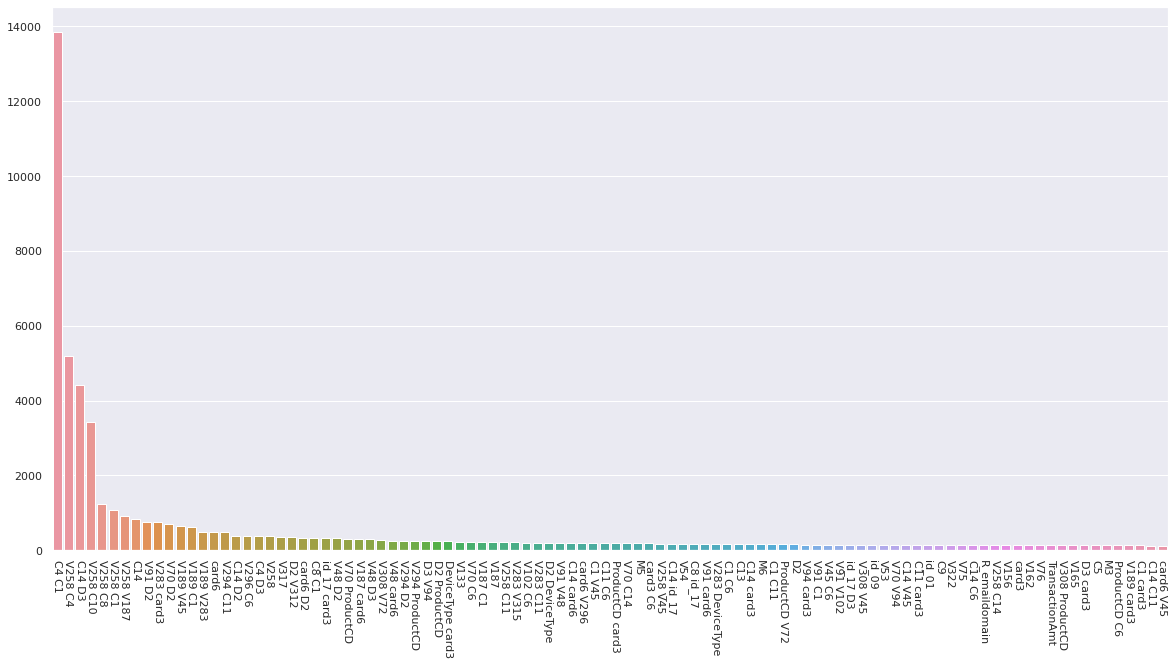

In [31]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_rfe_pol = ml_pipeline(X=R_.loc[:, rfe_polynom_recall_xgb.support_], y=y, n_splits=10, model=model, impute=False)

## SMOTE

In [15]:
transaction = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')
identity = df.read_csv('./data/train_identity.csv', header=0, ).set_index('TransactionID')

In [16]:
data = transaction.join(identity, how='left')

In [17]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.1, random_state=SEED)

In [18]:
sample = df.concat([sample_pos, sample_neg]).compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [19]:
sample.to_csv('./data/big_sample.csv', header=True, index=True)

In [46]:
data = pandas.read_csv('./data/big_sample.csv', header=0, dtype=types).set_index('TransactionID')

In [47]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,89760,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,90193,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,90246,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,90295,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987288,90986,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [48]:
X.drop(columns=['TransactionDT'], inplace=True)

In [49]:
categorical = X.select_dtypes(include=['category']).columns
numerical = X.select_dtypes(exclude=['category']).columns

In [50]:
negatives = X[numerical].loc[:, X[numerical].min()<0].min()

In [51]:
X[categorical] = X[categorical].apply(encode, result_type='broadcast',axis=0).astype('category')
X.loc[:, negatives.index] = X.loc[:, negatives.index].add(-negatives.values)
X[numerical] =  numpy.log10(X[numerical].add(1))

In [52]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4,4.261715,2.766413,31.0,3.0,72.0,1.0,2.401401,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,1.580902,0,4.127558,2.017033,54.0,3.0,23.0,1.0,NaN,NaN,...,22.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,463.0
2987243,1.580902,0,4.127558,2.017033,54.0,3.0,23.0,1.0,NaN,NaN,...,22.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,463.0
2987245,1.580902,0,4.127558,2.017033,54.0,3.0,23.0,1.0,NaN,NaN,...,22.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,463.0
2987288,2.194573,0,4.219558,2.737193,54.0,3.0,72.0,1.0,NaN,NaN,...,39.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN


In [53]:
R_ = X.copy(deep=True)

In [54]:
R_ = preprocess(R_, polynomial=polynomial_f)

In [55]:
R_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V45 DeviceType,V45 V312,V45 V281,V45 C6,DeviceType V312,DeviceType V281,DeviceType C6,V312 V281,V312 C6,V281 C6
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.0,4.261715,2.766413,31.0,3.0,72.0,1.0,2.401401,32.0,...,0.000000,0.0,0.0,0.143628,0.0,0.0,0.00000,0.0,0.0,0.0
2987240,1.580902,0.0,4.127558,2.017033,54.0,3.0,23.0,1.0,2.437368,32.0,...,0.301030,0.0,0.0,0.090619,0.0,0.0,0.30103,0.0,0.0,0.0
2987243,1.580902,0.0,4.127558,2.017033,54.0,3.0,23.0,1.0,2.437368,32.0,...,0.477121,0.0,0.0,0.143628,0.0,0.0,0.30103,0.0,0.0,0.0
2987245,1.580902,0.0,4.127558,2.017033,54.0,3.0,23.0,1.0,2.437368,32.0,...,0.602060,0.0,0.0,0.181238,0.0,0.0,0.30103,0.0,0.0,0.0
2987288,2.194573,0.0,4.219558,2.737193,54.0,3.0,72.0,1.0,2.437368,32.0,...,0.301030,0.0,0.0,0.090619,0.0,0.0,0.30103,0.0,0.0,0.0


In [56]:
R_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77650 entries, 2987203 to 3577539
Columns: 867 entries, TransactionAmt to V281 C6
dtypes: category(46), float64(821)
memory usage: 493.4 MB


In [173]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_rfe_smote = ml_pipeline(X=R_.loc[:, rfe_polynom_recall_xgb.support_], y=y, n_splits=10, model=model, impute=False, visualize=False, printout=True, polynomial=False, smote=True)

precision: 0.8915, recall: 0.7397, f1: 0.8086, aucPR: 0.8978, aucROC: 0.9421
precision: 0.8859, recall: 0.7252, f1: 0.7976, aucPR: 0.8946, aucROC: 0.9411
precision: 0.8908, recall: 0.7383, f1: 0.8074, aucPR: 0.8995, aucROC: 0.9442
precision: 0.8915, recall: 0.7401, f1: 0.8088, aucPR: 0.9032, aucROC: 0.9451
precision: 0.9039, recall: 0.7333, f1: 0.8097, aucPR: 0.9069, aucROC: 0.9492
precision: 0.8888, recall: 0.7193, f1: 0.7951, aucPR: 0.8905, aucROC: 0.9370
precision: 0.8901, recall: 0.7294, f1: 0.8018, aucPR: 0.8959, aucROC: 0.9406
precision: 0.8905, recall: 0.7280, f1: 0.8011, aucPR: 0.8964, aucROC: 0.9441
precision: 0.8955, recall: 0.7304, f1: 0.8046, aucPR: 0.8965, aucROC: 0.9456
precision: 0.8857, recall: 0.7202, f1: 0.7944, aucPR: 0.8936, aucROC: 0.9392
Final - precision: 0.8914, recall: 0.7304, f1: 0.8029, aucPR: 0.8975, aucROC: 0.9428


## Bayesian Optimization

In [32]:
R_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3564207
Columns: 867 entries, TransactionAmt to V281 C6
dtypes: category(46), float64(821)
memory usage: 311.9 MB


In [43]:
optimizer = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        random_state=SEED,
        eval_metric='auc'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        'reg_alpha': (1e-4, 1.0, 'uniform'),
        'reg_lambda': (1e-4, 1.0, 'log-uniform'),
        'min_child_weight': (0, 5),
        'max_depth': (3, 10),
        'max_delta_step': (0, 10),
        'min_split_loss': (1e-9, 1., 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'colsample_bynode': (0.01, 1.0, 'uniform'),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = JOBS,
    n_iter = 100,   
    verbose = 0,
    refit = False,
    random_state = SEED
)

In [44]:
def status_print(optim_result):

    all_models = pandas.DataFrame(optimizer.cv_results_)    
    best_params = pandas.Series(optimizer.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        numpy.round(optimizer.best_score_, 4),
        optimizer.best_params_
    ))

In [45]:
result = optimizer.fit(R_.loc[:, rfe_polynom_recall_xgb.support_].values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.8114
Best params: OrderedDict([('colsample_bylevel', 0.5356545233026259), ('colsample_bynode', 0.6793187137881445), ('colsample_bytree', 0.6264826551031426), ('learning_rate', 0.6502131416609406), ('max_delta_step', 9), ('max_depth', 10), ('min_child_weight', 1), ('min_split_loss', 0.0016369617038672708), ('reg_alpha', 0.5860764887088651), ('reg_lambda', 0.000931456627446469), ('subsample', 0.07025834820938834)])

Model #2
Best ROC-AUC: 0.9136
Best params: OrderedDict([('colsample_bylevel', 0.26578794535302064), ('colsample_bynode', 0.979114621842098), ('colsample_bytree', 0.9093539899332748), ('learning_rate', 0.6033485692808513), ('max_delta_step', 3), ('max_depth', 4), ('min_child_weight', 4), ('min_split_loss', 0.5786869156532723), ('reg_alpha', 0.1180650856696655), ('reg_lambda', 0.0005670271111039718), ('subsample', 0.42147776228999245)])

Model #3
Best ROC-AUC: 0.9136
Best params: OrderedDict([('colsample_bylevel', 0.26578794535302064), ('colsample_bynod

In [61]:
model = XGBClassifier(random_state=SEED,
                      n_jobs=JOBS,
                      learning_rate=0.39950743177244114,
                      max_delta_step=10,
                      max_depth=10,
                      min_child_weight=1,
                      min_split_loss=1e-9,
                      reg_alpha=0.2370155334625268,
                      reg_lambda=1.0,
                      subsample=0.8723919681623099,
                      colsample_bylevel=1.0,
                      colsample_bynode=1.0,
                      colsample_bytree=1.0)

xgb_rfe_smote_bayes = ml_pipeline(X=R_.loc[:, rfe_polynom_recall_xgb.support_], y=y, n_splits=10, model=model, impute=False, visualize=False, printout=True, polynomial=False, smote=True)

precision: 0.9005, recall: 0.7929, f1: 0.8433, aucPR: 0.9272, aucROC: 0.9597
precision: 0.8987, recall: 0.7987, f1: 0.8458, aucPR: 0.9238, aucROC: 0.9585
precision: 0.8990, recall: 0.8007, f1: 0.8470, aucPR: 0.9279, aucROC: 0.9622
precision: 0.9019, recall: 0.8185, f1: 0.8582, aucPR: 0.9347, aucROC: 0.9659
precision: 0.9110, recall: 0.7977, f1: 0.8506, aucPR: 0.9335, aucROC: 0.9648
precision: 0.8933, recall: 0.7865, f1: 0.8366, aucPR: 0.9216, aucROC: 0.9559
precision: 0.8976, recall: 0.7894, f1: 0.8401, aucPR: 0.9207, aucROC: 0.9569
precision: 0.9029, recall: 0.8054, f1: 0.8514, aucPR: 0.9295, aucROC: 0.9620
precision: 0.9091, recall: 0.8035, f1: 0.8530, aucPR: 0.9276, aucROC: 0.9640
precision: 0.8991, recall: 0.7894, f1: 0.8407, aucPR: 0.9245, aucROC: 0.9590
Final - precision: 0.9013, recall: 0.7983, f1: 0.8467, aucPR: 0.9271, aucROC: 0.9609


# Prediction and Submission

In [3]:
types = {'TransactionAmt': 'float32',
         'ProductCD': 'category',
         'addr1': 'float32',
         'addr2': 'category',
         'dist1': 'float32',
         'dist2': 'float32',
         'P_emaildomain': 'category',
         'R_emaildomain': 'category',
         'card1': 'float32',
         'card2': 'float32',
         'card3': 'category',
         'card4': 'category',
         'card5': 'category',
         'card6': 'category'}

types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({f'V{i}': 'float32' for i in range(1, 340)})
types.update({(f'id_0{i}' if i<10 else f'id_{i}'): 'float32' for i in range(1, 12)})
types.update({f'id_{i}': 'category' for i in range(12, 39)})
types.update({'DeviceType': 'category', 'DeviceInfo': 'category'})

In [4]:
data = pandas.read_csv('./data/big_sample.csv', header=0, dtype=types).set_index('TransactionID')
y = data['isFraud']
X = data.drop(columns=['isFraud'])

In [5]:
X.drop(columns=['TransactionDT'], inplace=True)

In [6]:
categorical = X.select_dtypes(include=['category']).columns
numerical = X.select_dtypes(exclude=['category']).columns
negatives = X[numerical].loc[:, X[numerical].min()<0].min()

In [7]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')
pol = PolynomialFeatures(interaction_only=True)
label_encoders = [LabelEncoder() for _ in range(len(categorical))]
polynomial_f = ['V258', 'V294', 'V91', 'V70', 'C8', 'C14', 'V187', 'V189', 'id_17', 'C4', 'card6', 'V48', 'D2', 'V308', 'V94',
                'D3', 'C1', 'C11', 'ProductCD', 'C10', 'V102', 'V296', 'V315', 'C5', 'V283', 'V45', 'DeviceType', 'V312', 'V281', 'C6']

In [8]:
X.loc[:, negatives.index] = X.loc[:, negatives.index].add(-negatives.values)
X[numerical] =  numpy.log10(X[numerical].add(1))
X.loc[:, numerical] = mean_imp.fit_transform(X.loc[:, numerical]) 
X.loc[:, categorical] = mode_imp.fit_transform(X.loc[:, categorical])
labels = {}
for idx, category in enumerate(categorical):
    X[category] = label_encoders[idx].fit_transform(X[category])
    labels[category] = {k:v for k,v in zip(label_encoders[idx].classes_, label_encoders[idx].transform(label_encoders[idx].classes_))}
pol_ = pandas.DataFrame(data=pol.fit_transform(X[polynomial_f]),
                                         columns=pol.get_feature_names(X[polynomial_f].columns),
                                         index=X.index)
            
pol_.drop(columns=polynomial_f, inplace=True)
X = X.join(pol_, how='left')
X[categorical] = X[categorical].astype('category')

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77650 entries, 2987203 to 3577539
Columns: 867 entries, TransactionAmt to V281 C6
dtypes: category(46), float64(821)
memory usage: 493.4 MB


In [10]:
rfe_polynom_recall_xgb = pickle.load(open('./artifacts/rfe_polynom_recall_xgb.pkl', 'rb'))

In [11]:
X_train = X.loc[:, rfe_polynom_recall_xgb.support_]

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77650 entries, 2987203 to 3577539
Columns: 220 entries, TransactionAmt to V312 C6
dtypes: category(16), float64(204)
memory usage: 125.4 MB


In [41]:
transaction = pandas.read_csv('./data/test_transaction.csv', header=0).set_index('TransactionID')
identity = pandas.read_csv('./data/test_identity.csv', header=0).set_index('TransactionID')

In [42]:
test_data = transaction.join(identity, how='left')

In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.7+ GB


In [49]:
test_data.to_csv('./data/test_data.csv', header=X.columns, index=True)

In [50]:
del test_data
del transaction
del identity

In [30]:
X_test = pandas.read_csv('./data/test_data.csv', header=0, dtype=types).set_index('TransactionID')
X_test.drop(columns=['TransactionDT'], inplace=True)

In [31]:
categorical = X_test.select_dtypes(include=['category']).columns
numerical = X_test.select_dtypes(exclude=['category']).columns
negatives = X_test[numerical].loc[:, X_test[numerical].min()<0].min()

In [32]:
X_test.loc[:, negatives.index] = X_test.loc[:, negatives.index].add(-negatives.values)
X_test[numerical] =  numpy.log10(X_test[numerical].add(1))
X_test.loc[:, numerical] = mean_imp.transform(X_test.loc[:, numerical]) 
X_test.loc[:, categorical] = mode_imp.transform(X_test.loc[:, categorical])
X_test[categorical] = X_test[categorical].astype('category')

for category in categorical:
    
    mode = X_test[category].mode()[0]
    categories = X_test[category].cat.categories.values
    for key in categories:
        if key not in labels[category]:
            if mode not in labels[category]:
                labels[category][key] = 0
            else:
                labels[category][key] = mode

    X_test[category] = X_test[category].map(labels[category])
    
pol_ = pandas.DataFrame(data=pol.transform(X_test[polynomial_f]),
                                         columns=pol.get_feature_names(X_test[polynomial_f].columns),
                                         index=X_test.index)
            
pol_.drop(columns=polynomial_f, inplace=True)
X_test = X_test.join(pol_, how='left')
X_test[categorical] = X_test[categorical].astype('category')

In [33]:
X_test = X_test.loc[:, rfe_polynom_recall_xgb.support_]

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 220 entries, TransactionAmt to V312 C6
dtypes: category(16), float64(204)
memory usage: 821.2 MB


In [35]:
X_test.head()

,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,dist1,dist2,...,V296 C6,V315 C5,V315 DeviceType,V315 V312,V315 C6,C5 V312,V45 V312,DeviceType V312,DeviceType V281,V312 C6
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,1.517855,4.017451,2.049218,31,3,72,2,2.232996,0.301030,1.559864,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3663550,1.698970,3.630733,2.049218,31,3,72,2,2.477121,0.698970,1.559864,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.569577,0.0,0.0,0.569577
3663551,2.235528,3.650987,2.759668,31,3,72,2,2.674861,3.420945,1.559864,...,0.371272,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3663552,2.456290,4.040998,2.557507,31,3,40,2,2.313867,1.255273,1.559864,...,0.000000,0.738311,0.0,0.000000,0.738311,0.000000,0.000000,0.0,0.0,0.000000
3663553,1.838534,4.255731,2.656098,31,2,7,2,2.423246,0.845098,1.559864,...,0.000000,0.877204,0.0,3.380208,1.430658,0.877204,0.553454,0.0,0.0,1.430658


In [36]:
categorical_features = [X_train.columns.get_loc(column) for column in X_train.select_dtypes(include=['category']).columns]
resampler = SMOTENC(sampling_strategy='minority', categorical_features=categorical_features, random_state=SEED, n_jobs=JOBS, k_neighbors=5)
X_train, y = resampler.fit_resample(X_train, y)

In [37]:
model = XGBClassifier(random_state=SEED,
                      n_jobs=JOBS,
                      learning_rate=0.39950743177244114,
                      max_delta_step=10,
                      max_depth=10,
                      min_child_weight=1,
                      min_split_loss=1e-9,
                      reg_alpha=0.2370155334625268,
                      reg_lambda=1.0,
                      subsample=0.8723919681623099,
                      colsample_bylevel=1.0,
                      colsample_bynode=1.0,
                      colsample_bytree=1.0)

In [38]:
model.fit(X=X_train.values, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1.0, colsample_bytree=1.0, gamma=9.99999972e-10,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.39950743177244114, max_delta_step=10,
              max_depth=10, min_child_weight=1, min_split_loss=1e-09,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=10, num_parallel_tree=1, random_state=0,
              reg_alpha=0.2370155334625268, reg_lambda=1.0, scale_pos_weight=1,
              subsample=0.8723919681623099, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [39]:
y_pred = model.predict(X_test.values)

In [40]:
result = pandas.DataFrame(data=y_pred, index=X_test.index)

In [41]:
result.to_csv('./artifacts/submission.csv', index=True, header=['isFraud'])